# Spectral Methods Part II: Chapter 8

Ernesto Barraza-Valdez, June 24, 2024

This notebook follows *Implementing Spectral Methods for Partial Differential Equations* by Dr. David Kopriva.

This is the final of several notebooks that covers Chapters 8 of Dr. Kopriva's textbook.

In this notebook, you are expected to know some Julia and to follow along the book. 
Because Julia has many useful libraries and packages for linear algebra (such as BLAS) and fourier transforms (such as FFTW) we will put those to use in order to focus more on advanced methods for non-periodic problems. 

In [1]:
#Check if Julia is working by checking version
VERSION

v"1.10.3"

We will activate a project in order to keep all Julia Packages useful for the rest of the notebooks

In [2]:
] activate .

  Activating project at `/dfs6/pub/ernestob/Julia/git/Implementing-Spectral-Methods`


If you haven't already created the project from the previous notebook uncomment the next code cell and run it. If the project is already created then you can leave it commented

In [3]:
# ] add BenchmarkTools FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia Revise

In [4]:
using FFTW
using Base.Threads
using LinearAlgebra
using SparseArrays
using Test
using TimerOutputs
using HDF5
using Printf
using FastGaussQuadrature
using ApproxFun
using FastTransforms
using FastChebInterp
using Polynomials
using SpecialPolynomials
using BenchmarkTools
using Latexify
using Plots
using LaTeXStrings
using IncompleteLU
using Preconditioners 
using IterativeSolvers
using LinearMaps
using RecursiveFactorization
using LinearOperators
using Krylov
using IJulia
using Revise

# Creating a Julia Package

We need to create a package in Julia to store all our functions from Chapters 1-4. 

We can follow the following links for `Pkg.jl`: 

https://pkgdocs.julialang.org/v1/creating-packages/

and `Revise.jl`

https://timholy.github.io/Revise.jl/stable/

Where `Revise.jl` makes it easy to revise any of the source code of the package.

First we generate a package with the base package of `Pkg.jl`

Notice that in Jupyter we can use the bracket `]` to access `Pkg` mode

If you have not done this, go ahead and uncomment the below cell

In [5]:
# ] generate Part2b

A Part I directory was added. Navigating through it we can access the src directory where we will put the Chapter 1-3 code

Next we need to use a terminal app and open Julia. Navigate to this folder.

Activate a project there and add the packages needed for Chapters 1-3. 

Such as the following steps:

```
$> cd ./Part1
$> julia
```

then in Julia

```
] activate .
```
```
] add BenchmarkTools LinearAlgebra SparseArrays FFTW Test TimerOutputs HDF5 Printf FastGaussQuadrature ApproxFun FastTransforms Polynomials SpecialPolynomials FastChebInterp Latexify Plots LaTeXStrings IncompleteLU Preconditioners IterativeSolvers LinearMaps RecursiveFactorization LinearOperators Krylov IJulia
```

After we paste our code from the previous notebook. 

After doing the above we can import the Part1 package. First we need to add it to the scope

In [6]:
push!(LOAD_PATH, "Part2b/");


Then we just use the `using`

In [7]:
using Part2b

Part 1, and 2a functions are now fully loaded

# Ch 8 Spectral Element Methods
-----------------------

# 8.1 Spectral Element Method in One Space Dimension

# 8.1.1 The Continuous Galerkin Spectral Element Method

Diffusion Equation: 

\begin{align}
    \varphi_t &= \varphi_{xx} + f(x), \;\;\;\;\;\;\;\;\; 0<x<L, \\
    \varphi(0,t) &= \varphi(L,t) = 0, \;\;\;\;\;\;\;\;\; t>0, \\
    \varphi(x,0) &= \varphi_0(x), \;\;\;\;\;\;\;\;\; 0<x<L,
\tag{8.5}
\end{align}

We use the Legendre Polynomial approximation so we need to convert the $x \in [0,L]$ domain to $\xi \in [-1,1]$:

\begin{align}
    &x = X^k(\xi) = x_{k-1} + \frac{\xi + 1}{2} \Delta x_k \\
    &\Delta x = x_k - x_{k-1}
\tag{8.10}
\end{align}

so 

\begin{align}
    dx = \frac{\Delta x_k}{2} d\xi, \:\:\:\:\:\;\;\;\;\; \frac{\partial}{\partial x} = \frac{2}{\Delta x_k} \frac{\partial}{\partial \xi},
\tag{8.11}
\end{align}

Where the subscript or superscript $k$ is the element (subinterval) of the domain

For each element $k$ we get: 

\begin{align}
    \sum_{j=0}^{N} \left[  w_j \frac{\Delta x_k }{2} \dot{\Phi}^k_j  + \frac{2}{\Delta x_k} \sum_{m=0}^{N} \Phi_m^k G_{jm} - w_j \frac{\Delta x_k }{2} F_j^k \right] \phi_j^k = 0
\tag{8.19}
\end{align}

and for the entire domain: 

\begin{align}
    \sum_{k=1}^K \sum_{j=0}^{N} \left[  w_j \frac{\Delta x_k }{2} \dot{\Phi}^k_j  + \frac{2}{\Delta x_k} \sum_{m=0}^{N} \Phi_m^k G_{jm} - w_j \frac{\Delta x_k }{2} F_j^k \right] \phi_j^k = 0
    \tag{8.20}
\end{align}


If we take $\phi^k_j$ equal to 1 at an interior node $\xi^k_j$ of an element and zero elsewhere we get for the $k^{th}$ element that the interior node solution satisfies:

\begin{align}
     w_j \frac{\Delta x_k }{2} \dot{\Phi}^k_j  =  -\frac{2}{\Delta x_k} \sum_{m=0}^{N} \Phi_m^k G_{jm} + w_j \frac{\Delta x_k }{2} F_j^k \\
     j = 1,2,...,N, \;\;\;\;\; k=1,2,...,K
\tag{8.21}
\end{align}


With the boundary conditions for each element being:

\begin{align}
    \left(  w_N \frac{\Delta_{k-1}}{2} + w_0 \frac{\Delta_{k}}{2} \right) \dot{\Phi}_*^k = &-\frac{2}{\Delta x_{k-1}} \sum_{m=0}^{N} \Phi_m^{k-1} G_{Nm} + w_N \frac{\Delta x_{k-1} }{2} F_N^{k-1} \\
    &-\frac{2}{\Delta x_k} \sum_{m=0}^{N} \Phi_m^k G_{0m} - w_0 \frac{\Delta x_k }{2} F_0^k
\tag{8.23}
\end{align}

For $k = 0,1,2,...,K-1$. Where $\Phi_0^k = \Phi_N^{k-1} = \Phi_*^k$

And finally we add the full domain boundary conditions: $\Phi_0^1 = \Phi_N^K = 0$

## 8.1.2 How to Implement

Because Julia is not an object-oriented language we need to heavily modify the **class** algorithms of the book. Luckily, Julia's makes up for it's lack of object oriented capabilities with easy to use mathematical functions.

Anyways, one way to mimick the object oriented **classes** is by using Julia's `mutable struct {}`.

A mutable stuct is like a struct in C and C++. We try to follow the Book's class algorithms with Julia's structs below.

In [7]:
#alg 116
#Ch 8.1.2.1 pg 302
#Data storage for one dimensional spectral element  method
mutable struct SEM1D

    N::Int64 #Total Nodes N+1
    K::Int64 #total elements
    xi::Array{Float64} #node locations
    wk::Array{Float64} #Gauss-Lobatto quad weights
    wbk::Array{Float64} #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    Phi::Array{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    RHS::Array{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    # G::Array{Float64} #Derivative Matrix


end

#seperate struct for element boundary pointers
mutable struct EPK

    eleft::Vector{Int64}
    eright::Vector{Int64}
    nodeleft::Vector{Int64}
    noderight::Vector{Int64}

end

In [8]:
#alg 117.
#ch 8.1.2.2 pg 304
# Global masking for 1D Spectral Element
function maskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    nR = 0
    for k in 1:K-1
        # kk=k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        a[nR] = 0.0

    end
    

end

#alg 117.
#ch 8.1.2.2 pg 304
# Global unmasking for 1D Spectral Element
function unmaskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    nR = 0
    nL = 0
    for k in 1:K-1
        # kk=k
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)
        
        a[nR] = a[nL]

    end
    

end

#alg 117.
#ch 8.1.2.2 pg 304
# Global sum for 1D Spectral Element
function globalsumSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    tmp = 0.0
    nR = 0
    nL = 0
    #might need to handle the k=0 element somehow
    for k in 1:K-1
        # kk = k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)

        tmp = a[nR] + a[nL] #a[jR,eR] + a[jL,eL]
        a[nR] = tmp # a[jR,eR] = tmp
        a[nL] = tmp # a[jL,eL] = tmp

    end
    

end

globalsumSEM! (generic function with 1 method)

In [9]:
#alg 118 with all together
#ch 8.1.2.3 pg 306
# Spatial Approximation for 1D Spectral Elements

#Alg 66
#eqn 5.77
#and eqn 5.79
#Laplace Operator anonymous function for LinearOperators.jl
LapOpSEM = (xi::Array{Float64}, dxk::Array{Float64}, wk::Array{Float64}, wbk::Array{Float64}, N::Int64, K::Int64) -> (dPhi,Phi,alpha,beta) -> begin

    #uses barycentric weights
    #set all to zeros
    @. dPhi = 0.0
    #println(length(dPhi))

    for k in 1:K
        for j in 0:N
            jj=j+1
            nn = jj + (k-1)*N
            for m in 0:N
                mm=m+1
                ll = mm + (k-1)*N
                dPhi[nn] = dPhi[nn]+CNGLaplacianElement(xi[:,k],wk[:,k],wbk[:,k], j,m)*Phi[ll]
            end
            dPhi[nn] = dPhi[nn]*2.0/dxk[k]
        end
    end


end

LapOpSEMA = (xi::Array{Float64}, dxk::Array{Float64}, wk::Array{Float64}, wbk::Array{Float64}, N::Int64, K::Int64) -> (dPhi,Phi,alpha,beta) -> begin

    #uses barycentric weights
    #set all to zeros
    @. dPhi = 0.0
    #println(length(dPhi))

    for k in 1:K
        for j in 0:N
            jj=j+1
            nn = jj + (k-1)*N
            for m in 0:N
                mm=m+1
                ll = mm + (k-1)*N
                dPhi[nn] = dPhi[nn]+CNGLaplacianElement(xi[:,k],wk[:,k],wbk[:,k], j,m)*Phi[ll]
            end
            dPhi[nn] = -dPhi[nn]*4.0/dxk[k]^2/wk[jj,k]
        end
    end


end

#matrix action
#We do not need to mask because Julia makes it easy to do mathematical operations on the correct elements. 
#We leave the masking part of the algorithm in comments just for learning purposes
function rhsSEM!(sem::SEM1D, pk::EPK, dt::Float64, maskpk::Array{Int64}, unmaskpk::Array{Int64}, lap) 
#uses barycentric weights
    #set all to zeros
    N = sem.N
    K = sem.K
    #unmask 
    # for m in 1:length(maskpk)
    #     #global sum
    #     # dPhi[unmaskpk[m]] =  dPhi[unmaskpk[m]] + dPhi[maskpk[m]]
    #     sem.RHS[maskpk[m]] = sem.RHS[unmaskpk[m]]
    #     #mask dPhi
    #     # dPhi[maskpk[m]] = 0
    # end
    # unmaskSEM!(sem.Phi, pk,N,K)
    # Phi = @view(sem.Phi[:]) #to simplify its use in code
    # dPhi = @view(sem.RHS[:]) #to simplify it's use in code
    @. sem.RHS = 0.0
    #println(length(dPhi))
    

    sem.RHS .= lap*sem.Phi
    dt2 = dt/2.0
    
    for n in 1:K*N+(K-1)-1
        nn=n+1
        k = floor(Int64,n/(N+1))
        kk = k+1
        j = mod( n,N+1)
        jj = j+1
        #Trapezoidal Integration Matrix action
        sem.RHS[nn] = sem.wk[jj,kk]/2.0 * sem.dxk[kk] * sem.Phi[nn] -  dt2 * sem.RHS[nn]
    end

    # globalsumSEM!(sem.RHS, pk,N,K)
    # maskSEM!(sem.RHS, pk, N, K)
    for m in 1:length(maskpk)
        #global sum
        sem.RHS[unmaskpk[m]] =  sem.RHS[unmaskpk[m]] + sem.RHS[maskpk[m]]
        sem.RHS[maskpk[m]] = sem.RHS[unmaskpk[m]]
        #mask dPhi
        # dPhi[maskpk[m]] = 0
    end
    #set boundary conditions
    sem.RHS[1] = 0.0
    sem.RHS[end] = 0.0;
    # maskSEM!(sem.Phi, pk,N,K)

    
end


rhsSEM! (generic function with 1 method)

In [10]:
LHSOp = (xk::Array{Float64}, dxk::Array{Float64}, wk::Array{Float64}, wbk::Array{Float64}, dt::Float64, maskpk::Array{Int64}, unmaskpk::Array{Int64}, N::Int64, K::Int64, lap::LinearOperator) -> (dPhi,Phi,alpha,beta) -> begin

#uses barycentric weights
    dt2 = dt/2.0
    #set all to zeros
    @. dPhi = 0.0
    #println(length(dPhi))
    #unmask 
    # unmaskSEM!(Phi, pk, N, K)
    dPhi .= lap*Phi

    for n in 1:K*N+(K-1)-1
        nn=n+1
        k = floor(Int64,n/(N+1))
        kk = k+1
        j = mod( n,N+1)
        jj = j+1
        #Trapezoidal Integration Matrix action LHS
        dPhi[nn] = wk[jj,kk]/2.0 * dxk[kk] * Phi[nn] + dt2 * dPhi[nn]
        # #check if in boundary to mask
        # if n in maskpk
            
        # end
    end

    
    for m in 1:length(maskpk)
        #global sum
        dPhi[unmaskpk[m]] =  dPhi[unmaskpk[m]] + dPhi[maskpk[m]]
        dPhi[maskpk[m]] = dPhi[unmaskpk[m]]
        #mask dPhi
        # dPhi[maskpk[m]] = 0
    end

    dPhi[1] = 0.0
    dPhi[end] = 0.0
    # globalsumSEM!(dPhi, pk, N, K)
    # maskSEM!(dPhi, pk, N, K)
    # #set boundary conditions
    # dPhi[1] = 0.0
    # dPhi[end] = 0.0
    # maskSEM!(Phi, pk, N, K)

    
end

#9 (generic function with 1 method)

In [11]:
#alg 119
#ch 8.1.2.3 pg 307
# Integration of the 1D Spectral Element method in time
function TrapezoidalRuleIntegration(sem::SEM1D, pk::EPK, NT::Int64, dt::Float64, lap, LHSop, maskpk::Array{Int64}, unmaskpk::Array{Int64}, tol::Float64, Nit::Int64)


    t = 0.0
    pphi = zeros(Float64, length(sem.Phi))
    for n in 0:NT-1
        #IJulia.clear_output(true)
        println("Time Step: ",n)
        t = n*dt
        #set rhs
        rhsSEM!(sem, pk, dt,  maskpk, unmaskpk, lap) 
        # unmaskSEM!(sem.Phi, pk, sem.N, sem.K)
        
        (pphi, stats) = Krylov.bicgstab(LHSop, sem.RHS)#, sem.Phi; atol=tol, itmax = Nit)        
        @. sem.Phi = pphi

        # globalsumSEM!(dPhi, pk, N, K)
        # maskSEM!(dPhi, pk, N, K)
        #set boundary conditions
        # dPhi[1] = 0.0
        # dPhi[end] = 0.0
        # maskSEM!(Phi, pk, N, K)
        if mod(n,20)==0.0
            println(stats)
        end

    end

    unmaskSEM!(sem.Phi, pk, sem.N, sem.K)
    println("Finished")


end

TrapezoidalRuleIntegration (generic function with 1 method)

## 8.1.3 Benchmarking

We solve **Eqn 8.5**.

The exact analytical solution for an initial gaussian heat spot is:

\begin{align}
    \varphi(x,t) = \frac{e^{-x^2/(4 t + 1)}}{\sqrt{4 t + 1}}
\tag{8.30}
\end{align}

In [12]:
# cooling gaussian spot eqn 8.30
#N+1 nodes per element
N = 10
#number of elements
K = 3
#total number of nodes
ntot = N*K

#domain is from [-8,8] with a total of N*K nodes and K elements
#set element domains
omega1 = [-8.0, -3.0]
omega2 = [-3.0, 3.0]
omega3 = [3.0, 8.0]

#2*avg of length of elements
avxk1 = omega1[2]+omega1[1]
avxk2 = omega2[2]+omega2[1]
avxk3 = omega3[2]+omega3[1]
#length of elements
dxk1 = omega1[2]-omega1[1]
dxk2 = omega2[2]-omega2[1]
dxk3 = omega3[2]-omega3[1]

5.0

In [13]:
#build nodes for each element
xleg, wleg = LegendreGaussLobattoNodesAndWeights(N, 100000, 1.0e-9);
wb = BarycentricWeights(xleg);

In [14]:
#set up full domain in real x
#Eqn 8.10
xreal = [dxk1/2.0*xleg[i] + avxk1/2.0 for i in 1:length(xleg)]
xreal = vcat(xreal, [dxk2/2.0*xleg[i] + avxk2/2.0 for i in 1:length(xleg)])
xreal = vcat(xreal, [dxk3/2.0*xleg[i] + avxk3/2.0 for i in 1:length(xleg)]);

In [15]:
#initial conditions for Eqn 8.30
t0 = 0.0
gspot(x,t) =  exp(-x^2/(4.0*t+1))/sqrt(4.0*t+1)
xx = [-8.0 + i*16.0/100.0 for i in 0:100 ];
#make an initial condition array for plotting and copying
gausspot0 = @. gspot(xx, 0.0)
#Make an array to run over time
gausspot = @. gspot(xreal, 0.0);#exp(-xreal^2/(4*t0+1))/sqrt(4*t0+1);

Let's check out our initial conditions and take a notice of the nodes and where the elements begin and end

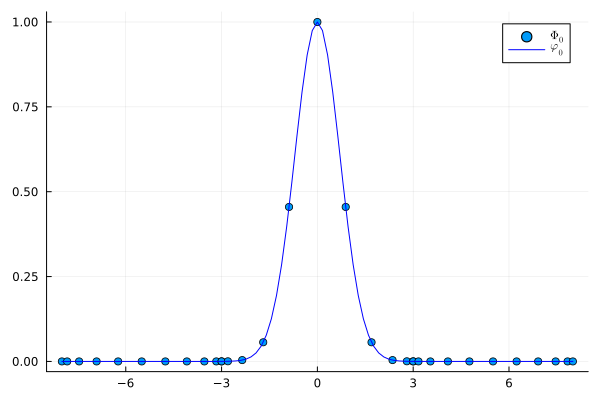

In [16]:
plot(xreal,gausspot, seriestype=:scatter,label=L"\Phi_0", format=:png)
plot!(xx, gausspot0, color=:blue,label=L"\varphi_0")

Let's make arrays that holds information of the nodes, weights, barycentric weights, element ends, and dx for each element

In [17]:
xi = [xleg[j] for j in 1:N+1, k in 1:K]
wk = [wleg[j] for j in 1:N+1, k in 1:K];
wkb = [wb[j] for j in 1:N+1, k in 1:K];
xk = [-8.0, -3.0, 3.0, 8.0]
dxk = [dxk1, dxk2, dxk3];



Initialize our 1D Spectral Element Struct

In [18]:
sem1D = SEM1D(N, K, xi, wk, wkb, xk, dxk, zeros(Float64, K*length(xleg)) , zeros(Float64, K*length(xleg)));

Set the struct's $\varphi$ values to initial conditions

In [19]:
@. sem1D.Phi = gausspot;

Now we need to set our list of nodes and it's neighbors.

In [20]:
eleft = [k for k in 1:K-1]
eright = eleft .+ 1
nodeleft = [N for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPK(eleft, eright, nodeleft, noderight);

Let's check these out. How many nodes are on the right and what are their normalized $\xi$

In [21]:
epk.eright

2-element Vector{Int64}:
 2
 3

This tells us that only elements 2 and 3 serve as right neighbors to other elements. 

In [22]:
epk.noderight

2-element Vector{Int64}:
 0
 0

Here we see that elements 2 and 3 have starting $\xi$ values of zero. 

Now let's take a cleaner look at the element structures

In [23]:
jR = 0
eR = 0
nR = 0
maskpk = [0,0]
println("element \t el-R \t Node-R \t nR")
println("-------------------------------------------")
for k in 1:K-1
    # kk=k+1
    jR = epk.noderight[k]
    eR = epk.eright[k]
    #convert to 1D array index
    nR = (eR-1)*(N+1) + jR+1
    maskpk[k] = nR
    println(k, "\t:\t", eR, "\t:\t", jR,  "\t:\t",nR)
end

element 	 el-R 	 Node-R 	 nR
-------------------------------------------
1	:	2	:	0	:	12
2	:	3	:	0	:	23


Here we see that elements 1 and 2 serve as left neighbors to elements 2 and 3 (respectively) with their $\xi$ starting at zero. The starting node index in the 1D array of nodes is `12` for element 1 and `23` for element 2.

Similarly, we can do it for the left points.

In [24]:
unmaskpk = [0,0]
println("element \t el-L \t Node-L \t nL")
println("-------------------------------------------")
for k in 1:K-1
    # kk=k+1
    jL = epk.nodeleft[k]
    eL = epk.eleft[k]
    #convert to 1D array index
    nL = (eL-1)*(N+1) + (jL+1)
    unmaskpk[k] = nL
    println(k, "\t:\t", eL, "\t:\t", jL,  "\t:\t",nL)
end

element 	 el-L 	 Node-L 	 nL
-------------------------------------------
1	:	1	:	10	:	11
2	:	2	:	10	:	22


-----------
Now set up the laplacian operator for the spectral elements. We first have to input the variables into the anonymous function as below

In [25]:
lapopsem = LapOpSEM(xi, dxk, wk, wkb, N, K) # -> (dPhi,Phi,alpha,beta) -> 
# lapopsemA = LapOpSEMA(xi, dxk, wk, wkb, N, K)

#2 (generic function with 1 method)

Next we need to convert the laplacian function into an operatorusing `LinearOperators.jl`

In [26]:
lapop = LinearOperator(Float64, K*length(xleg), K*length(xleg), false, false,
                     (res, v) -> lapopsem(res, v, 1.0, 1.0),
                     nothing,
                     nothing)
# lapopA = LinearOperator(Float64, K*length(xleg), K*length(xleg), false, false,
#                      (res, v) -> lapopsemA(res, v, 1.0, 1.0),
#                      nothing,
#                      nothing)

Linear operator
  nrow: 33
  ncol: 33
  eltype: Float64
  symmetric: false
  hermitian: false
  nprod:   0
  ntprod:  0
  nctprod: 0



In order to get our LHS operator, we need our time step. We set $\Delta t = 0.04$

First, we assign variables to the anonymous function

In [27]:
dt = 0.01
LHS = LHSOp(xk, dxk, wk, wkb, dt, maskpk, unmaskpk, N, K, lapop) # -> (dPhi,Phi,alpha,beta) ->

#10 (generic function with 1 method)

Convert our LHS function into an operator

In [28]:
lhsop = LinearOperator(Float64, K*length(xleg), K*length(xleg), false, false,
                     (res, v) -> LHS(res, v, 1.0, 1.0),
                     nothing,
                     nothing)

Linear operator
  nrow: 33
  ncol: 33
  eltype: Float64
  symmetric: false
  hermitian: false
  nprod:   0
  ntprod:  0
  nctprod: 0



### Simulation

For the first simulation, we'll run for $t = 0.2 s$

In [29]:
#total real time
ttotal = 0.2
#calculate number of time steps
Nt = floor(Int64, ttotal/dt)
#set our solution tolerance
tol = 1.0e-12
#set maximum number of iterations to use
Nit = 10000;
Nt

20

In [30]:
#make a copy of the original SEM struct so we can time evolve the copy and plot against the initial conditions of the original
sema = deepcopy(sem1D);


Run the trapezoidal integration

In [31]:
TrapezoidalRuleIntegration(sema, epk, Nt, dt, lapop, lhsop, maskpk, unmaskpk, tol, Nit)

Time Step: 0
SimpleStats
 niter: 8
 solved: true
 inconsistent: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 timer: 89.05ms
 status: solution good enough given atol and rtol

Time Step: 1
Time Step: 2
Time Step: 3
Time Step: 4
Time Step: 5
Time Step: 6
Time Step: 7
Time Step: 8
Time Step: 9
Time Step: 10
Time Step: 11
Time Step: 12
Time Step: 13
Time Step: 14
Time Step: 15
Time Step: 16
Time Step: 17
Time Step: 18
Time Step: 19
Finished


For the second simulation we'll run for $t=0.8 s$

In [32]:
ttotal = 0.8
Ntb = floor(Int64, ttotal/dt)
semb = deepcopy(sem1D);
Ntb

80

In [33]:
TrapezoidalRuleIntegration(semb, epk, Ntb, dt, lapop, lhsop, maskpk, unmaskpk, tol, Nit)

Time Step: 0
SimpleStats
 niter: 8
 solved: true
 inconsistent: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 timer: 2.30ms
 status: solution good enough given atol and rtol

Time Step: 1
Time Step: 2
Time Step: 3
Time Step: 4
Time Step: 5
Time Step: 6
Time Step: 7
Time Step: 8
Time Step: 9
Time Step: 10
Time Step: 11
Time Step: 12
Time Step: 13
Time Step: 14
Time Step: 15
Time Step: 16
Time Step: 17
Time Step: 18
Time Step: 19
Time Step: 20
SimpleStats
 niter: 10
 solved: true
 inconsistent: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 timer: 3.66ms
 status: solution good enough given atol and rtol

Time Step: 21
Time Step: 22
Time Step: 23
Time Step: 24
Time Step: 25
Time Step: 26
Time Step: 27
Time Step: 28
Time Step: 29
Time Step: 30
Time Step: 31
Time Step: 32
Time Step: 33
Time Step: 34
Time Step: 35
Time Step: 36
Time Step: 37
Time Step: 38
Time Step: 39
Time Step: 40
SimpleStats
 niter: 10
 solved: true
 inconsistent: false
 residuals: []
 Aresiduals: []
 κ₂(A): []
 time

Let's calculate the analytical solutions for these two times

In [34]:
gausspotta = @. gspot(xx, dt*Nt);
gausspottb = @. gspot(xx, dt*Ntb);

Plot the SEM simulation vs the analytical solutions

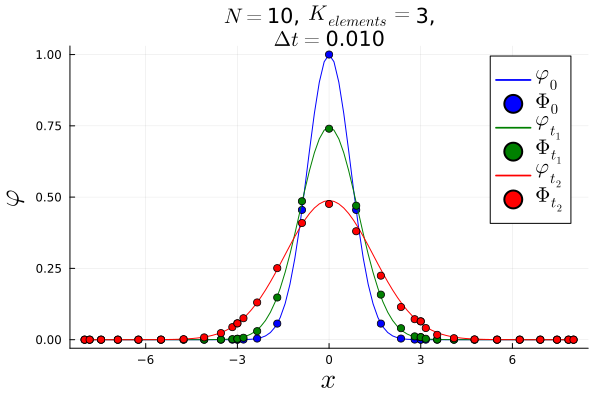

In [35]:
plot(xx, gausspot0, color=:blue,label=L"\varphi_0", format=:png)
plot!(xreal,gausspot, color=:blue,seriestype=:scatter,label=L"\Phi_0", format=:png)
plot!(xx, gausspotta, color=:green,label=L"\varphi_{t_1}")
plot!(xreal,sema.Phi, color=:green,seriestype=:scatter,label=L"\Phi_{t_1}", format=:png)
plot!(xx, gausspottb, color=:red,label=L"\varphi_{t_2}")
plot!(xreal,semb.Phi, color=:red, seriestype=:scatter,label=L"\Phi_{t_2}", format=:png)
        
# plot!(xout1, phiout1,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[1])))
# plot!(xana, phi1ana, color=:green,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[1])))
# plot!(xout2, phiout2,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[2])))
# plot!(xana, phi2ana, color=:yellow,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[2])))
# plot!(xout3, phiout3,seriestype=:scatter,markeralpha=0.5,label=latexstring(@sprintf("\\Phi_{t=%.1f}",tout[3])))
# plot!(xana, phi3ana, color=:red,label=latexstring(@sprintf("\\varphi_{t=%.1f}",tout[3])))
plot!(legendfontsize=14)
xlabel!(L"x",xlabelfontsize=18)
ylabel!(L"\varphi", ylabelfontsize=18)
plot!(title=L"N="* string(@sprintf("%d,", N), L"\:\:\:K_{elements} = ", @sprintf("%d,", K))*"\n"*L"\Delta t = "*@sprintf("%.3f", dt))

Which is **Figure 8.7**

# 8.1.4 Discontinuous Galerkin Spectral Element Method

The Discontinuous Galerkin Spectral Element Method (DGSEM) is similar to the Continuous Galerkin Spectral Element method. However, it does not enforce the boundary continuation at each element interface for a smoothe differentiable function. This is helpeful for problems that have discontinuous solutions such as shocks. 

The DGSEM is, more specifically, very good at modelling conservation laws in the form:

\begin{align}
    \partial_t \mathbf{q} + \partial_x \mathbf{f} = 0, \:\:\:\:\:\:\: x \in \left[ 0, L \right]
\tag{8.31}
\end{align}

Where we call $\mathbf{f}$ the **Flux**

Please follow along in the book as the math gets a bit too tedious to re-write here. You will notice that we can re-purpose our code from the previous section. 

## 8.1.6a Riemann Problems and Numerical Fluxes

We will skip ahead to 8.1.6 to review the math of Riemann Problems.

Because numerical methods are only approximations to solutions of partial differential equations, there will be numerical error. For the DGSEM this becomes a hurdle when the solution is discontinuous at each element's boundaries. To reduce this error, we need to add what is called **Numerical Flux**. The **Numerical Flux** will compensate for the errors in the calculated flux. There are many methods that give useful numerical fluxes to overcome the boundary issues. The main principle is to develop the **Riemann Problem** and use the solution as the **Numerical Flux**. We will do that below.

Consider the Acoustic wave equation: 

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 \:\:\: K_0 \\
    \frac{1}{\rho_0} \:\:\: 0  
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\tag{R0}
\end{align}



Now let's set our simulation parameters. We will use the equilibrium density $\rho_0 = 1$, the bulk modulus $K_{0} = 1$, and sound speed $c = \sqrt{K_{0}/\rho_0}$

With these parameters, it gives us the equation of the book:

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 \:\:\: 1 \\
    1\:\:\: 0  
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\tag{8.45}
\end{align}

We will use the initial condition of:

\begin{align}
    p &= 2^{-\left( x - 1 \right)^2/b^2}\\
    u &= 0
\tag{R0A}
\end{align}

with $b = 0.15$

### Flux and Riemann Solver

Here we can follow along in the book after **Eqn 8.45** on **Page 315**.

The flux $\mathbf{f}$ for this problem is:

\begin{align}
    \mathbf{f} = \underline{\mathbf{A}} \cdot \mathbf{\bar{q}}
\tag{R1}
\end{align}

where 

\begin{align}
    \underline{\mathbf{A}} = \left[ \begin{array}{cc} 
    0 \:\:\: K_0 \\
    \frac{1}{\rho_0} \:\:\: 0  
    \end{array}\right]
\tag{R2}
\end{align}

For a suitable matrix, like $\underline{\mathbf{A}}$, we can diagonalize as:

\begin{align}
    \underline{\mathbf{A}} = \underline{\mathbf{S}}\cdot\underline{\mathbf{\lambda}}\cdot\underline{\mathbf{S}}^{-1}
\tag{R3}
\end{align}

Where $\underline{\mathbf{\lambda}}$ is the eigenvalue matrix. 

Thus the flux can be re-written as:

\begin{align}
    \mathbf{f} = \underline{\mathbf{S}}\cdot\underline{\mathbf{\lambda}}\cdot\underline{\mathbf{S}}^{-1} \cdot \mathbf{\bar{q}}
\end{align}

This can then be split into the right ($+$) and left ($-$) going waves with the normal pointing in the $+$ direction. 

\begin{align}
    \mathbf{f} &= \underline{\mathbf{S}}\cdot \left( \underline{\mathbf{\lambda}}^+ + \underline{\mathbf{\lambda}}^- \right) \cdot\underline{\mathbf{S}}^{-1} \cdot \mathbf{\bar{q}} \\ 
    \mathbf{f} &= \underline{\mathbf{S}}\cdot \left( \underline{\mathbf{\lambda}}^+\right) \cdot\underline{\mathbf{S}}^{-1} \cdot \mathbf{\bar{q}} + \underline{\mathbf{S}}\cdot \left(\underline{\mathbf{\lambda}}^- \right) \cdot\underline{\mathbf{S}}^{-1} \cdot \mathbf{\bar{q}} \\ 
    \mathbf{f} &= \mathbf{W}^+ + \mathbf{W}^-
\tag{R4}
\end{align}

where $\mathbf{W}^+$ is our right going wave flux and $\mathbf{W}^-$ is the left going wave flux for a normal pointing in the $+$ direction

The eigenvalues of $\underline{A}$ are:

\begin{align}
    \lambda_1 &= c = \sqrt{K/\rho_0} \\
    \lambda_2 &= -c
\tag{R5}
\end{align}

with eigen vectors: 

\begin{align}
    \left[ \begin{array}{cc} 
   K_0\:\rho_0 \\
    1 
    \end{array}\right], \left[ \begin{array}{cc} 
   -K_0\:\rho_0 \\
    1 
    \end{array}\right]
\tag{R6}
\end{align}


Define the diagonalization as: 

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
   K_0\:\rho_0 & -K_0\:\rho_0 \\
    1 & 1 
    \end{array}\right]
\tag{R7}
\end{align}

This is the right eigenvector matrix.

Then the inverse (or Hermitian Conjugate for complex values) of the right eigenvector matrix is the left-eigenvector matrix.

\begin{align}
    \underline{S}^{-1} = \left[ \begin{array}{cc} 
   \frac{1}{2 \:\rho_0 \cdot K_0} & \frac{1}{2} \\
    \frac{-1}{2\: \rho_0 \cdot K_0} & \frac{1}{2} 
    \end{array}\right]
\tag{R8}
\end{align}

We also call these the transformation matrices.

and the eigen value matrix is:

\begin{align}
    \underline{\Lambda} = \left[ \begin{array}{cc} 
        c & 0 \\
        0 & -c 
    \end{array}\right]
\tag{R9}
\end{align}

We can split the eigenvalue matrix as a left ($\Lambda^-$) and right ($\Lambda^+$) going eigenvalue matrices as: 

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    c & 0 \\
    0 & 0
    \end{array}\right]
\tag{R10}
\end{align}

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    0  & 0 \\
    0 & -c
    \end{array}\right]
\tag{R11}
\end{align}

Now we can define the *impedance* of the wave as: 

\begin{align}
    Z = K_0 \: \rho_0
\tag{R12}
\end{align}

With these we re-write our eigen vector matrix as:

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
   K_0\:\rho_0 & -K_0\:\rho_0 \\
    1 & 1 
    \end{array}\right] = \left[ \begin{array}{cc} 
    Z & -Z \\
    1 & 1 
    \end{array}\right]
\end{align}

\begin{align}
    \underline{S}^{-1} = \frac{1}{2}\left[ \begin{array}{cc} 
   \frac{1}{Z} & 1 \\
    -\frac{1}{Z} & 1
    \end{array}\right] 
\end{align}

Applying these matrices to transform $\bar{q}$

\begin{align}
    \underline{S}^{-1} \cdot \bar{q} =  \frac{1}{2} \left[ \begin{array}{cc} 
   \frac{1}{Z} p + u  \\
    -\frac{1}{Z} p + u 
    \end{array}\right] = \frac{1}{2}  \left[ \begin{array}{cc} 
   w^+\\
    w^-
    \end{array}\right]
\end{align}

Then applying our left and right going eigenvalue matrices:

\begin{align}
    \underline{\Lambda}^{+} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   c \cdot w^+\\
    0
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{-} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   0\\
    -c \cdot w^-
    \end{array}\right]
\end{align}

Finally we apply **Eqn R4** to recuperate the flux:

\begin{align}
    F^* = \left( \underline{S} \cdot \underline{\Lambda}^{+} \cdot \underline{S}^{-1} +   \underline{S} \cdot\underline{\Lambda}^{-} \cdot \underline{S}^{-1}  \right)  \cdot \bar{q} = \frac{c}{2} \left[ \begin{array}{cc} 
   Z \left( w^+ + w^-  \right) \\
    w^+ - w^-
    \end{array}\right] = \frac{c}{2} \left[ \begin{array}{cc} 
     p^+ + Z\: u^+ - p^- + Z\: u^-   \\
    \frac{p^+}{Z} + u^+ + \frac{p^-}{Z} - u^- 
    \end{array}\right]
\tag{R13}
\end{align}

Now we have a way to calculate the flux at the boundary of each element with **Eqn R13**. **Eqn R13** should be applied to the two boundaries of each element. 

This analysis wasn't just useful for the flux. We can also obtain the analytical solution for this problem. To do this we recognize that:

\begin{align}
    w^+ &= \frac{p}{Z} + u \\ 
    w^- &= -\frac{p}{Z} + u
\tag{R14}
\end{align}


Returning to **Eqn R0** we can re-write as:

\begin{align}
    \partial_t \mathbf{\bar{q}} + \mathbf{\underline{A}}\cdot \partial_x \mathbf{\bar{q}} &= 0 \\
    \partial_t \mathbf{\bar{q}} + \mathbf{\underline{S}}\:\mathbf{\underline{\Lambda}}\:\mathbf{\underline{S}}^{-1}\cdot \partial_x \mathbf{\bar{q}} &= 0 \\
    \mathbf{\underline{S}}^{-1}\:\partial_t \mathbf{\bar{q}} + \mathbf{\underline{\Lambda}}\:\mathbf{\underline{S}}^{-1}\cdot \partial_x \mathbf{\bar{q}} &= 0 \\
    \mathbf{\underline{S}}^{-1}\:\partial_t \mathbf{\bar{q}} + \left( \mathbf{\underline{\Lambda}}^+ + \mathbf{\underline{\Lambda}}^- \right)\:\mathbf{\underline{S}}^{-1}\cdot \partial_x \mathbf{\bar{q}} &= 0 \\
\end{align}



The last line we can translate to:

\begin{align}
     \frac{\partial}{\partial t}\left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] +  \left[ \begin{array}{cc} 
   c & 0 \\
    0 & -c 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right] = 0
\tag{R15}
\end{align}



Using our initial conditions in **Eqn R0A**, with $u_0 = 0$, the method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2 Z} p_0 + \frac{1}{2} u_0 = \frac{1}{2 Z} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{2 Z} 2^{ -\frac{(x - c t -1)^2}{b^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = -\frac{1}{2 Z} p_0 + \frac{1}{2} u_0 = -\frac{1}{2 Z}2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = -\frac{1}{2 Z} 2^{ -\frac{(x + c t -1)^2}{b^2}   }
\end{align}

And

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \mathbf{\underline{S}} \cdot \mathbf{\bar{W}}=\left[ \begin{array}{cc} 
   Z && -Z \\
    1 && 1
    \end{array}\right] \cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] =   \left[ \begin{array}{cc} 
    Z \left( w^+ - w^-  \right)\\
    w^+ + w-
    \end{array}\right]
\end{align}


\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \left[ \begin{array}{cc} 
   \sqrt{K_0\:\rho_0} && -\sqrt{K_0\:\rho_0}  \\
    1 && 1
    \end{array}\right] \cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] =   \left[ \begin{array}{cc} 
    Z \left( w^+ - w^-  \right)\\
    w^+ + w-
    \end{array}\right]
\end{align}

So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} + 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)  \\
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} - 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}


## 8.1.5 How to Implement the Disctontinuous Galerkin Spectral Element Method

Let's get back to the coding

Again, we will have to use `mutable struct` object of Julia's. Below we hold all the variables we need in this struct. You may want to add more or delete some. However, once the `mutable struct` is compiled, you cannot change the properties of that `mutable struct`. For example, below we name the struct `DGSEM1D`. 

Once the cell is run, that piece of Julia code is compiled. The name `DGSEM1D` is now associated with a struct with certain properties. Those properties cannot be editted, deleted, or added. Therefore, to edit the struct after running the cell, you need to either restart the Julia kernel, or you rename the struct to something else such as `dgsem1d` (lowercase) and use that in the next cells. 

Or, we can do a trick. We can set another variable with a different name equal to `DGSEM1D`. Such as:

`DGSEM = DGSEM1D`

From there, we can reuse the name `DGSEM` in any of the following code so that it does not get distrubed by change in the `mutable struct DGSEM1D`. However, if the struct needs to be edited, you still need to change the name of the struct `mutable struct DGSEM1D` to something like `mutable struct dgsem1d` and then set: `DGSEM = dgsem1d`. We will do this. 

In [8]:
mutable struct DGSEM1D

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements

    Dhat::AbstractArray #First derivative matrix in x
    c::Float64 #speed of wave
    rho::Float64
    Kbulk::Float64
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGSEM1D() = new() #initialize struct as empty

end


In [9]:
#seperate struct for element boundary pointers
mutable struct EPKD

    eleft::AbstractArray{Int64}
    eright::AbstractArray{Int64}
    nodeleft::AbstractArray{Int64}
    noderight::AbstractArray{Int64}

end

Because we can't erase or rename structs when we change them we need to do a trick:

In [10]:
DGSEM = DGSEM1D

DGSEM1D

In [11]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstruct(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  c::Float64, rho::Float64, Kbulk::Float64, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    #wave variables
    NDG.c = c
    NDG.n = kvec
    NDG.rho = rho
    NDG.Kbulk = Kbulk
    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for i in 0:N[k]
                ii = i+1 
                Dh[ii,jj] = -Dx[jj,ii]*wk[k][jj]/wk[k][ii]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0

        end

    end

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point

    

    return xreal

end

NDGConstruct (generic function with 1 method)

In [12]:
#alg 61a
function InterpolateToBoundaryDGSEM1D!(Phi::Array{Float64}, Lj::Array{Float64})

    N = length(Phi)
    interpolatedValue = 0.0

    # for j in 0:N-1
    #     jj=j+1
    #     interpolatedValue = interpolatedValue + Phi[jj]*Lj[jj]
    # end
    interpolatedValue = sum(Phi.*Lj)

    return interpolatedValue
end



InterpolateToBoundaryDGSEM1D! (generic function with 1 method)

In [13]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    for n in 1:Neqn 
        dF[:, n] .= Dhat * F[:,n]
    
        @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    end

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [14]:
#alg 93
function DGSEM1DGlobalTimeDerivative!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    k=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
    k=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,k], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c, )
        elseif idR == -1
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        else
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, [NDG.rho, NDG.Kbulk], NDG.c)
            NDG.FL[:,idR] .= -NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.c)
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0*NDG.dF/NDG.dxk[k]
            
        
    end
    
    # SystemDGDerivative!(NDG.N, NDG.dF1[:,jj], NDG.dF2[:,jj], NDG.dF3[:,jj], NDG.F1[:,jj], NDG.F2[:,jj], NDG.F3[:,jj], NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, FstarL1, FstarL2, FstarL3, FstarR1, FstarR2, FstarR3)
    # SystemDGDerivative!(NDG.N, @view(NDG.dFx[:,1]), @view(NDG.dFx[:,2]), @view(NDG.dFx[:,3]), @view(NDG.Fx[:,1]), @view(NDG.Fx[:,2]), @view(NDG.Fx[:,3]), NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, NDG.FL, NDG.FR)

    # NDG.dQ1[:,jj] .= -1.0*NDG.dFx[:,1]
    # NDG.dQ2[:,jj] .= -1.0*NDG.dFx[:,2]
    # NDG.dQ3[:,jj] .= -1.0*NDG.dFx[:,3]



    
end

DGSEM1DGlobalTimeDerivative! (generic function with 1 method)

In [15]:
#alg 62
function DGSEMstep1DRK3!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivative!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3! (generic function with 1 method)

In [16]:
#alg 51d
function LegendreNDG1DWave!(NDG::DGSEM, pk::EPKD, NT::Int64, dt::Float64, Nout::Int64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    #dt = Ttot/NT
    #N = Int(length(Phi)) - 1
    tn = 0.0
    
    for n in 0:NT-1
        IJulia.clear_output(true)
        println("Time Step: ",n)
        
        @. NDG.G = 0
        @. NDG.dQ = 0

        # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
        DGSEMstep1DRK3!(NDG, pk, tn, dt, eindex, ExternalState, ReimannSolver, flux)
        tn = (n+1)*dt
        
        
    end

    return nothing
    
end

LegendreNDG1DWave! (generic function with 1 method)

## 8.1.6 Benchmarking NDG SEM



Now let's set our simulation parameters. We will use the equilibrium density $\rho_0 = 1$, the bulk modulus $K_{0} = 1$, and sound speed $c = \sqrt{K_{0}/\rho_0}$

With these parameters, it gives us the equation of the book:

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 \:\:\: 1 \\
    1\:\:\: 0  
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\tag{8.45}
\end{align}

We will use the initial condition of:

\begin{align}
    p &= 2^{-\left( x - 1 \right)^2/b^2}\\
    u &= 0
\tag{R0A}
\end{align}

with $b = 0.15$

Let's initialize our DGSEM struct as empty

In [22]:
dsem = DGSEM()

DGSEM1D(#undef, 0, 0, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, 0.0, 0.0, 0.0, #undef, #undef, #undef)

In [27]:
t0 = 0.0
rho = 1.0
Kbulk = 1.0
c = 1.0#sqrt(bulK/rho)
z = sqrt(rho*Kbulk)
zinv = 1.0/z
kx = sqrt(1.0)
# ky = sqrt(0.25)
X0 = 1.5
omega = c*kx
b = 0.15
Fp0(x,t) = 2^(-(x - X0)^2/b^2)
Fp(x,t) = 0.5*(2^(-((x-X0) - c*t)^2/b^2) + 2^(-((x-X0) + c*t)^2/b^2))#2.0^(-(x-X0)^2/b^2) #
Fu0(x,t) = 0.0#1.0/c * Fp0(x,t)#kx/omega*exp(-(kx*(x-1.0) -omega*t)^2/b^2) 
Fu(x,t) = 0.5*(2^(-((x-X0) - c*t)^2/b^2) - 2^(-((x-X0) + c*t)^2/b^2))
Fun = [Fp0, Fu0]

2-element Vector{Function}:
 Fp0 (generic function with 1 method)
 Fu0 (generic function with 1 method)

In [28]:
#create our normal vector in the 1D x-driection
kvec = [1.0, -1.0]


2-element Vector{Float64}:
  1.0
 -1.0

Chose $x \in [0,5]$ with $N = 30$ and number of elements $K = 9$

In [29]:
xtot = [0.0, 5.0]
#use Nvec to indicate how many equations we're solving. In this case it's 2 equations, p and u
Nvec = 2
K = 9
NN = 30
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

Construct the necessary variables for the NDGSEM. It spits out the real coordinates of $x$

In [30]:
xreal = NDGConstruct(dsem, N, K, "leg", Nvec, Fun,  c, rho, Kbulk, kvec, t0,  xk);

Now let's make the functions for the initial conditions

In [31]:
xx = [0.0 + i*5.0/100 for i in 0:100]
pana0 = Fp0.(xx,0.0);
p00 = Fp.(xx,0.0);
uana0 = Fu0.(xx,0.0);
p0 = Fp0.(xreal,0.0);
u0 = Fu0.(xreal,0.0);

Plot NDGSEM initial conditions with analytical

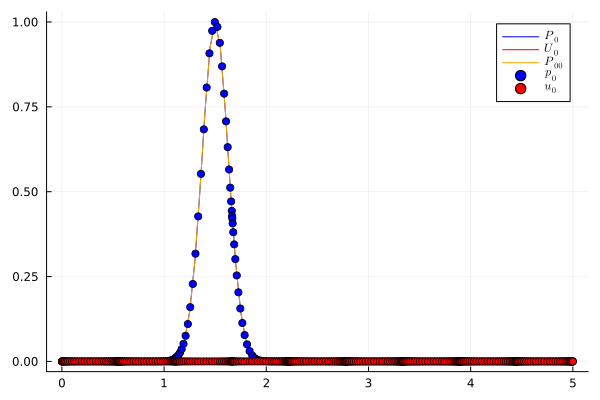

In [32]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, pana0, color=:blue,label=L"P_0", format=:png)
plot!(xx, uana0, color=:red,label=L"U_0", format=:png)
plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)
plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"u_0", format=:png)

Let's take a look at the boundaries of the elements given by `xk`

In [33]:
#element real location boundaries
xk

10-element Vector{Float64}:
 0.0
 0.5555555555555556
 1.1111111111111112
 1.6666666666666667
 2.2222222222222223
 2.7777777777777777
 3.3333333333333335
 3.8888888888888893
 4.444444444444445
 5.0

No we need to make an array to indicate the element indices in our 1D array

In [34]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

Let's check out which indices (nodes) belong to each element:

In [35]:
for k in 1:K
    #left boundary index
    lpoint = elindex[2*k-1]
    #right boundary index
    rpoint = elindex[2*k]
    println("Element ", k, "\t",lpoint,":", rpoint)
end

Element 1	1:31
Element 2	32:62
Element 3	63:93
Element 4	94:124
Element 5	125:155
Element 6	156:186
Element 7	187:217
Element 8	218:248
Element 9	249:279


Now we make our **pointers** to the element boundaries

In [38]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

Let's check out where the left boundaries point to

In [39]:
epk.eleft

10-element Vector{Int64}:
 -1
  1
  2
  3
  4
  5
  6
  7
  8
  9

and the right

In [40]:
epk.eright

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 -1

Now we repurpose **Algorithm 88** from Chapter 5 for the NDGSEM

In [36]:
#alg 88 NDG::NDG2DWaves
function ReimannSolverNDG1D(QL::AbstractArray, QR::AbstractArray, normal::Float64, n::AbstractArray, c::Float64)

    Z = sqrt(n[1]*n[2])
    Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
    pplus = QL[1]
    pminus = QR[1]
    uplus = QL[2]
    uminus = QR[2]

    F1 =  normal*c/2.0*(pplus + uplus - pminus + uminus)#normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

    return [F1, F2]
    

end

ReimannSolverNDG1D (generic function with 1 method)

Here we repurpose **Algorithm 64** for our Riemann Flux

In [37]:
#alg 64
function Flux(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, rhobulk::AbstractArray, c::Float64)

    F[:,1] = c^2 * Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


Flux (generic function with 1 method)

We repurpose the external free propagation solution from Chapter 5

In [41]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagation(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = 0.0#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#-Qint[2]#Fu(xy,t)#Fu0(xy,t)

    end
    return Qext
end

ExtFunFreePropagation (generic function with 1 method)

We need to take into consideration the **CFL** condition. An approximate formula is the total real domain divided by the total number of unique nodes

In [45]:
#CFT Number
ddxx = xtot[2] /(Ntot - K)
CFT = 1.0
ddtt = CFT/c*ddxx


0.018518518518518517

This is our approximate minimum $\Delta t$. We choose: $\Delta t = 0.001$ and run a total of 1.5 seconds

In [46]:
dsema = deepcopy(dsem)
dt = 1.0e-3
ttot = 1.5
NT = floor(Int64, ttot/dt)


1500

In [49]:
tn = 0.0
for n in 0:NT
    if mod(n,50) == 0
        
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    DGSEMstep1DRK3!(dsema, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1D, Flux)
    tn = (n+1)*dt
    
    
end

Time Step: 1500


In [50]:
pt = Fp.(xx,dt*(NT+1))
ut = Fu.(xx,dt*(NT+1));

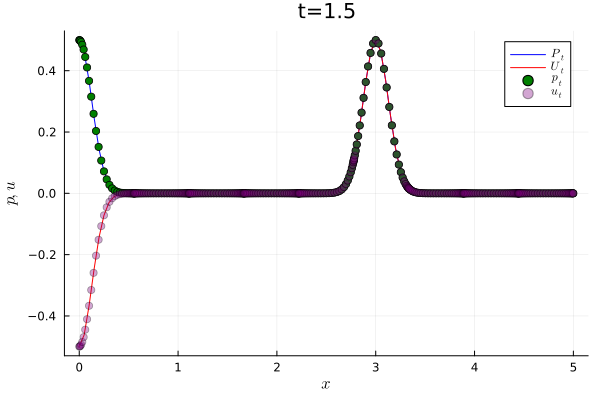

In [55]:
plot(xx, pt, color=:blue,label=L"P_t", format=:png)
plot!(xx, ut, color=:red,label=L"U_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"p_t", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,alpha=0.35,seriestype=:scatter,label=L"u_t", format=:png)
plot!(title="t=1.5")
xlabel!(L"x")
ylabel!(L"p, u")

# WIth a discontinuous boundary

In [572]:
mutable struct DGSEM1Dd

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray #speed of wave
    rho::AbstractArray
    Kbulk::AbstractArray
    Z::AbstractArray
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGSEM1Dd() = new()

end


In [573]:
#seperate struct for element boundary pointers
mutable struct EPKD

    eleft::AbstractArray{Int64}
    eright::AbstractArray{Int64}
    nodeleft::AbstractArray{Int64}
    noderight::AbstractArray{Int64}

end

Because we can't erase or rename structs when we change them we need to do a trick:

In [574]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstruct(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    #wave variables
    # NDG.c = c
    NDG.n = kvec
    # NDG.rho = rho
    # NDG.Kbulk = Kbulk
    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for i in 0:N[k]
                ii = i+1 
                Dh[ii,jj] = -Dx[jj,ii]*wk[k][jj]/wk[k][ii]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0

        end

    end

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point

    

    return xreal

end

NDGConstruct (generic function with 4 methods)

In [575]:
#alg 61a
function InterpolateToBoundaryDGSEM1D!(Phi::Array{Float64}, Lj::Array{Float64})

    N = length(Phi)
    interpolatedValue = 0.0

    # for j in 0:N-1
    #     jj=j+1
    #     interpolatedValue = interpolatedValue + Phi[jj]*Lj[jj]
    # end
    interpolatedValue = sum(Phi.*Lj)

    return interpolatedValue
end



InterpolateToBoundaryDGSEM1D! (generic function with 1 method)

In [576]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    for n in 1:Neqn 
        dF[:, n] .= Dhat * F[:,n]
    
        @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    end

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [577]:
#alg 93
function DGSEM1DGlobalTimeDerivative!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    k=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
    k=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,k], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, c, Kbulk, rho, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, c, Kbulk, rho, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*k]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            rho = [NDG.rho[lpoint], NDG.rho[rpoint]]
            Kbulk = [NDG.Kbulk[lpoint], NDG.Kbulk[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, c, Kbulk, rho, Z)
            NDG.FL[:,idR] .= -NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.rho[lpoint:rpoint], NDG.c[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0*NDG.dF/NDG.dxk[k]
            
        
    end
    
    # SystemDGDerivative!(NDG.N, NDG.dF1[:,jj], NDG.dF2[:,jj], NDG.dF3[:,jj], NDG.F1[:,jj], NDG.F2[:,jj], NDG.F3[:,jj], NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, FstarL1, FstarL2, FstarL3, FstarR1, FstarR2, FstarR3)
    # SystemDGDerivative!(NDG.N, @view(NDG.dFx[:,1]), @view(NDG.dFx[:,2]), @view(NDG.dFx[:,3]), @view(NDG.Fx[:,1]), @view(NDG.Fx[:,2]), @view(NDG.Fx[:,3]), NDG.Dhatx, NDG.wx, NDG.lp1x, NDG.ln1x, NDG.FL, NDG.FR)

    # NDG.dQ1[:,jj] .= -1.0*NDG.dFx[:,1]
    # NDG.dQ2[:,jj] .= -1.0*NDG.dFx[:,2]
    # NDG.dQ3[:,jj] .= -1.0*NDG.dFx[:,3]



    
end

DGSEM1DGlobalTimeDerivative! (generic function with 2 methods)

In [578]:
#alg 62
function DGSEMstep1DRK3!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivative!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3! (generic function with 2 methods)

In [579]:
#alg 51d
function LegendreNDG1DWave!(NDG::DGSEM, pk::EPKD, NT::Int64, dt::Float64, Nout::Int64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    #dt = Ttot/NT
    #N = Int(length(Phi)) - 1
    tn = 0.0
    
    for n in 0:NT-1
        IJulia.clear_output(true)
        println("Time Step: ",n)
        
        @. NDG.G = 0
        @. NDG.dQ = 0

        # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
        DGSEMstep1DRK3!(NDG, pk, tn, dt, eindex, ExternalState, ReimannSolver, flux)
        tn = (n+1)*dt
        
        
    end

    return nothing
    
end

LegendreNDG1DWave! (generic function with 2 methods)

## 8.1.6 Benchmarking NDG SEM



Acoustic wave equation: 

\begin{align}
    \frac{\partial}{\partial t} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] + \left[ \begin{array}{cc} 
    0 && \rho c^2  \\
    \frac{1}{\rho} && 0 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc}  
    p \\
    u
    \end{array}\right] = 0
\end{align}



In [580]:
DGSEM = DGSEM1Dd

DGSEM1Dd

In [581]:
dsem = DGSEM()

DGSEM1Dd(#undef, 140486735703168, 140488377241608, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

We also get:

\begin{align}
     \frac{\partial}{\partial t}\left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] +  \left[ \begin{array}{cc} 
   c\:\:\: 0 \\
    0\:\:\: -c 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right] = 0
\end{align}

\begin{align}
     \frac{\partial}{\partial t}\left[ \begin{array}{cc} 
    w^+ \\
    w^- 
    \end{array}\right] =   \left[ \begin{array}{cc} 
   -c\:\:\: 0 \\
    0\:\:\: c 
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]
\end{align}


The method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2} \left( \frac{p_0}{\rho c} + \alpha_x u_0  \right)= \frac{1}{2\rho c} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{2\rho c} 2^{ -\frac{(x - c t -1)^2}{b^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = \frac{1}{2} \left( -\frac{p_0}{\rho c} + \alpha_x u_0  \right) = -\frac{1}{2\rho c} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = -\frac{1}{2\rho c} 2^{ -\frac{(x + c t -1)^2}{b^2}   }
\end{align}



So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    p \\
    u
    \end{array}\right]  = \underline{P}\cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \rho c && -\rho c \\
    \alpha_x && \alpha_x
    \end{array}\right] \cdot  \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} + 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)  \\
    \frac{\alpha_x}{2\rho c} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} - 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}

Which we use calculate the external flux. Is this necessary? Is it necessary for waves moving through different material?

In [582]:
t0 = 0.0
rho0 = 1.0
rho1 = 0.75
Kbulk0 = 1.0
Kbulk1 = 1.00
c0 = sqrt(Kbulk0/rho0)
c1 = sqrt(Kbulk1/rho1)
z0 = sqrt(rho0*Kbulk0)
z1 = sqrt(rho1*Kbulk1)
#zinv = 1.0/z
X0 = 1.5
xmat = 3.0
omega = c*kx
b = 0.15


0.15

In [583]:
function speedc(x, xm=xmat)
    if x <=xm
        return c0
    elseif x>xm
        return c1
    end
end

#Fp0(x,t) = 2^(-(x - X0)^2/b^2)
Fp(x,t) = 0.5(2^(-((x-X0) - speedc(x)*t)^2/b^2) + 2^(-((x-X0) + speedc(x)*t)^2/b^2))#2.0^(-(x-X0)^2/b^2) #
#Fu0(x,t) = 0.0#1.0/c * Fp0(x,t)#kx/omega*exp(-(kx*(x-1.0) -omega*t)^2/b^2) 
Fu(x,t) = 0.5/rho0/speedc(x)*(2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
Fun = [Fp, Fu]

2-element Vector{Function}:
 Fp (generic function with 2 methods)
 Fu (generic function with 2 methods)

In [584]:
kvec = [1.0, -1.0]


2-element Vector{Float64}:
  1.0
 -1.0

In [585]:
xtot = [0.0, 5.0]
Nvec = 2
K = 10
NN = 30
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

In [586]:
xreal = NDGConstruct(dsem, N, K, "leg", Nvec, Fun,   kvec, t0,  xk);

In [587]:
c = zeros(Float64, length(xreal))
rho = zeros(Float64, length(xreal))
kbulk = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

for i in 1:length(xreal)
    if xreal[i] <= xmat
        rho[i] = rho0
        kbulk[i] = Kbulk0
        c[i] = c0
        Z[i] = z0
    elseif xreal[i] > xmat
        rho[i] = rho1
        kbulk[i] = Kbulk1
        c[i] = c1
        Z[i] = z1
    end
end

In [588]:
dsem.c = c
dsem.rho = rho
dsem.Kbulk = kbulk
dsem.Z = Z;

In [589]:
xx = [0.0 + i*5.0/100 for i in 0:100]
pana0 = Fp.(xx,0.0);
#p00 = Fp.(xx,0.0);
uana0 = Fu.(xx,0.0);
p0 = Fp.(xreal,0.0);
u0 = Fu.(xreal,0.0);

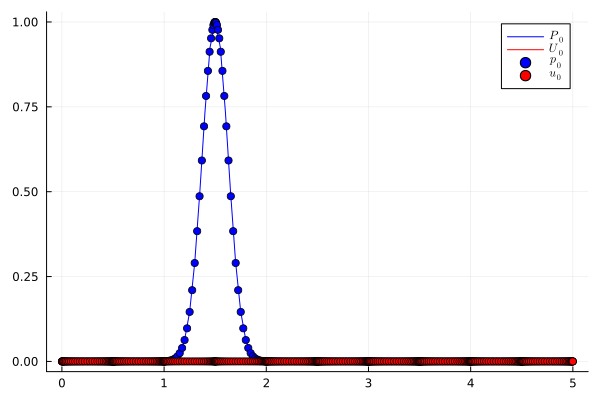

In [590]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, pana0, color=:blue,label=L"P_0", format=:png)
plot!(xx, uana0, color=:red,label=L"U_0", format=:png)
#plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)
plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"u_0", format=:png)

In [591]:
#element real location boundaries
#xk

In [592]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [593]:
elindex;

In [594]:
for k in 1:K
    #left boundary index
    lpoint = elindex[2*k-1]
    #right boundary index
    rpoint = elindex[2*k]
    println(lpoint,":", rpoint)
end

1:31
32:62
63:93
94:124
125:155
156:186
187:217
218:248
249:279
280:310


### Flux and Riemann Solver

Previously, we've only used the upwind scheme such that we find the characteristic variables $w^+$ & and $w^-$ and then multiply by the left $+$ and right $-$ eigenmatrix and diagonal:

\begin{align}
    F^* = \underline{P}\cdot \underline{\Lambda}^+ \cdot \bar{w}^+ + \underline{P}\cdot \underline{\Lambda}^- \cdot \bar{w}^-
\end{align}

Where, for this problem:

\begin{align}
    w^+ &= \frac{1}{2} \left(  \frac{p}{Z} + u  \right) \\
    w^- &= \frac{1}{2} \left(  -\frac{p}{Z} + u  \right)
\end{align}

In [595]:
#alg 88 NDG::NDG2DWaves
#UpwindScheme
function ReimannSolverNDG1DAcousticUpwind(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

    
    C=c[1]
    Rho = rho[1]
    pplus = QL[1]
    pminus = QR[1]
    uplus = QL[2]
    uminus = QR[2]

    F1 =  normal*C/2.0*(pplus + Rho*C*uplus - pminus + Rho*C*uminus)#normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*1.0/2.0/Rho*(pplus + Rho*C*uplus + pminus - Rho*C*uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)
    return [F1, F2]
end

ReimannSolverNDG1DAcousticUpwind (generic function with 1 method)

For discontinuities in materials such as density we need to calculate the numerical flux using the Rankin-Hugonoit Condition. 

In [596]:
#alg 88 NDG::NDG2DWaves
function ReimannSolverNDG1DRankineHugonoit(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

    cL = c[1]
    cR = c[2]
    rhoL = rho[1]
    rhoR = rho[2]
    kbulkL = kbulk[1]
    kbulkR = kbulk[2]
    ZL = rhoL*cL#/(rhoL*cL + rhoR*cR)#Z[1]#sqrt(n[1]*n[2])
    ZR = rhoR*cR#/(rhoL*cL + rhoR*cR)
    # #Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
    pL = QL[1]
    pR = QR[1]
    uL = QL[2]
    uR = QR[2]

    F1 = normal*(ZR*cL*(pL+ZL*uL) - ZL*cR*(pR-ZR*uR))/(ZR+ZL) #normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
    F2 = normal*(cL * (pL+ZL*uL) + cR* (pR-ZR*uR) )/(ZR+ZL)   #normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

    return [F1, F2]
end

ReimannSolverNDG1DRankineHugonoit (generic function with 1 method)

In [597]:
#alg 64
function FluxAcoustic(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, rhobulk::AbstractArray, c::AbstractArray)

    F[:,1] = rhobulk .* c.^2 .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0./ rhobulk .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxAcoustic (generic function with 1 method)

In [598]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [599]:
# epk.eleft

In [600]:
# epk.eright

In [601]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagationAcoustic(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#Qint[1]#Fp(xy,t)## #Fp(xy,t)
        Qext[2] = 0.0#-Qint[2]#Fu(xy,t)#Fu(xy,t)# #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#0.0#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#0.0#-Qint[2]#Fu(xy,t)#Fu0(xy,t)

    end
    return Qext
end

ExtFunFreePropagationAcoustic (generic function with 1 method)

In [602]:
#CFT Number
# ddxx = 5.0/(Ntot - K)
# CFT = 1.0
# ddtt = CFT/c*ddxx


In [603]:
dsema = deepcopy(dsem)
dt = 1.0e-3
ttot = 2.25
NT = floor(Int64, ttot/dt)


2250

In [604]:
tn = 0.0
for n in 0:NT

    if mod(n,20)==0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    DGSEMstep1DRK3!(dsema, epk, tn, dt, elindex, ExtFunFreePropagationAcoustic, ReimannSolverNDG1DRankineHugonoit, FluxAcoustic)
    tn = (n+1)*dt
    
    
end

Time Step: 2240


In [605]:
pt = Fp.(xx,dt*(NT+1))
ut = Fu.(xx,dt*(NT+1));

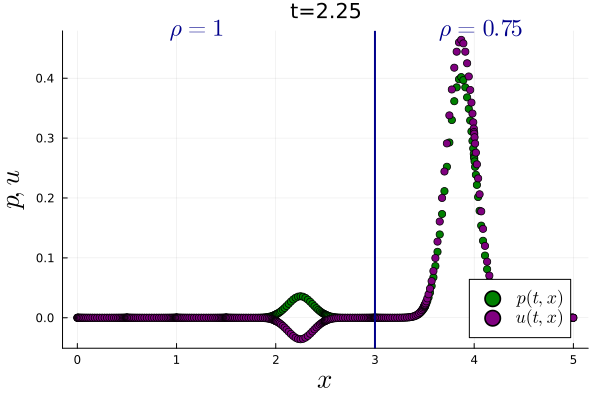

In [606]:
# plot(xx, pt, color=:blue,label=L"P_t", format=:png)
# plot!(xx, ut, color=:red,label=L"U_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"p(t,x)", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"u(t,x)", format=:png)
vline!([3], color=:darkblue, linewidth=2, label="")
annotate!(1.5, 0.48, text(L"\rho = 1", :darkblue, :right, 16))
annotate!(4.5, 0.48, text(L"\rho = 0.75", :darkblue, :right, 16))
plot!(title="t=2.25", legend=:bottomright, legendfontsize=12)
xlabel!(L"x", guidefont=18)
ylabel!(L"p,u", guidefont=18)

# Maxwell's Equations

\begin{align}
    &\bar{D} = \epsilon(x) \bar{E} \\
    &\bar{H} = \frac{1}{\mu(x)} \bar{B} \\
    &\frac{\partial}{\partial t} \bar{D} + \bar{J}_f = \bar{\nabla}\times \bar{H} \\ 
    -&\frac{\partial}{\partial t} \bar{B}  = \bar{\nabla}\times \bar{E}
\end{align}

In 1D with wave travelling in the x-direction and E-field in y-direction, H-field in the z-direction: 

\begin{align}
    & D_y = \epsilon(x) E_y \\
    & H_z = \frac{1}{\mu(x)} B_z \\
    &\frac{\partial}{\partial t} D_y  = \frac{\partial}{\partial x} H_z\\ 
    -&\frac{\partial}{\partial t} B_z  = \frac{\partial}{\partial x} E_y
\end{align}

we can re-write this in vector-matrix notation

\begin{align}
    \left[ \begin{array}{cc} 
    \epsilon(x) && 0 \\
    0 && \mu(x)
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && 1 \\
    1 && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\end{align}

or 

\begin{align}
    \left[ \begin{array}{cc} 
    1 && 0 \\
    0 && 1
    \end{array}\right]\cdot \frac{\partial}{\partial t} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]   + \left[ \begin{array}{cc} 
   0 && \frac{1}{\epsilon(x)} \\
    \frac{1}{\mu(x)} && 0
    \end{array}\right] \cdot \frac{\partial}{\partial x} \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right] = 0
\end{align}

Which can be re-written as:

\begin{align}
    \underline{Q} \frac{\partial }{\partial t} \bar{q} + \underline{A} \frac{\partial }{\partial x} \bar{q} = 0
\end{align}


The Flux is given by $\underline{A}\cdot \bar{q}$

The relative permativity is written as:

\begin{align}
    \epsilon_r(x) &= \frac{\epsilon(x)}{\epsilon_0}\\
    &\Rightarrow  \epsilon(x) = \epsilon_0\cdot \epsilon_r(x)
\end{align}

and similarly for $\mu(x)$

We will abosrb the vacuum constants into the E-field and H-Field:

\begin{align}
    E_y &\Rightarrow \epsilon_0 E_y \\
    H_z &\Rightarrow \mu_0 H_z
\end{align}

## Implementation

In [636]:
#need to make a new struct
mutable struct DGmaxwell

    N::Vector{Int64}
    K::Int64
    Neqn::Int64
    xi::AbstractArray #node locations
    wk::AbstractArray #Gauss-Lobatto quad weights
    wbk::AbstractArray #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xreal::Array{Float64}
    Q::AbstractArray{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::AbstractArray{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::AbstractArray{Float64} #Low Storage RK3
    QLint::Array{Float64} # solution at left element boundaries
    QRint::Array{Float64} #solution at right element boundaries
    QLext::Array{Float64} # solution at left element boundaries
    QRext::Array{Float64} #solution at right element boundaries
    F::AbstractArray{Float64} #flux
    dF::AbstractArray{Float64} 
    FR::Array{Float64} #numerical flux on the right of elements
    FL::Array{Float64} #numerical flux on left of elements
    Qminus::AbstractArray{Float64} #flux
    Qplus::AbstractArray{Float64} #flux

    Dhat::AbstractArray #First derivative matrix in x
    c::AbstractArray{Float64}  #speed of wave in material
    Z::AbstractArray{Float64}  #impedance of wave in material
    epsr::AbstractArray{Float64}  #relative permattivity of material
    mur::AbstractArray{Float64}  #relative permeabiilty in material
    n::Vector{Float64} #Normal Vector
    
    lp1::AbstractArray #langrange interpolation at x=1 boundary
    ln1::AbstractArray #langrange interpolation at x=-1 boundary
    DGmaxwell() = new()

end

In [637]:
#alg 59B
#NodalDiscontinuousGalerkinConstruct
function NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  kvec::Array{Float64}, t::Float64, xk::AbstractArray)
    #Inputs
    #NDGsystem - Struct containing all variables needed
    #N - Number of nodes from 0 to N in x-direction
    #M - Number of nodes from 0 to M in y-direction

    #set node points
    NDG.N = N
    NDG.K = K
    NDG.n = kvec

    #total number of equations of vector
    NDG.Neqn = Nvec
    #total number of points on grid
    Ntot = sum(N)+K
    #Ntot = K*(N+1)

    
    xi = []
    wk = []
    wkb = []
    for k in 1:K
        x, w = LegendreGaussNodesAndWeights(N[k], 100000, 1e-9)
        wb = BarycentricWeights(x)
        push!(xi, x)
        push!(wk,w)
        push!(wkb, wb)
        
        
    end

    NDG.xi = xi #[x[j] for j in 1:N+1, k in 1:K]
    NDG.wk = wk #[w[j] for j in 1:N+1, k in 1:K];
    NDG.wbk = wkb #[wb[j] for j in 1:N+1, k in 1:K];

    #calculate element domains
    NDG.xk = xk
    #set up full domain in real x
    #domain is from [-8,8] with a total of N*K nodes and K elements
    #set element domains
    dxk = zeros(Float64,K)
    avxk = zeros(Float64,K)
    for k in 1:K
        avxk[k] = xk[k+1] + xk[k]
        dxk[k] = xk[k+1] - xk[k]

    end
    #set dxk
    NDG.dxk = dxk
   
    
    #interpolation coefficients for l_j(+-1)
    ln1 = []
    lp1 = []
    for k in 1:K
        push!(ln1, LagrangeInterpolatingPolynomials(-1.0, xi[k],wkb[k],1.0e-12))
        push!(lp1, LagrangeInterpolatingPolynomials(1.0, xi[k],wkb[k],1.0e-12))
    end
    
    NDG.ln1 = ln1 #LagrangeInterpolatingPolynomials(-1.0, x,wb,1.0e-12)
    NDG.lp1 = lp1 #LagrangeInterpolatingPolynomials(1.0, x, wb,1.0e-12)

    #derivative matrix
    # Dx = PolynomialDerivativeMatrix(x)
    # NDG.Dhat = zeros(Float64, (size(Dx),K))
    Dhat = []

    for k in 1:K
        Dx = PolynomialDerivativeMatrix(xi[k])
        Dh = zeros(Float64, size(Dx))
        for j in 0:N[k]
            jj=j+1
            for n in 0:N[k]
                nn = n+1 
                Dh[jj,nn] = -Dx[nn,jj]*wk[k][nn]/wk[k][jj]
            end
        end
        push!(Dhat, Dh)
    end

    NDG.Dhat = Dhat;

    # for k in 2:K
    #     @. NDG.Dhat[:,:,k] = NDG.Dhat[:,:,1]
    # end

    #setting up initial conditions
    #calculate real positions
    #from affine map
    xreal = zeros(Float64, Ntot)
    # eps = zeros(Float64, Ntot)
    # mus = zeros(Float64, Ntot)
    # c = zeros(Float64, Ntot)
    for k in 1:K
        for j in 1:N[k]+1
            n = j + (k-1)*(N[k]+1)
            xreal[n] = dxk[k]/2.0*xi[k][j] + avxk[k]/2.0
        end

    end

    NDG.xreal = xreal

    NDG.Q = zeros(Float64, (Ntot, Nvec))
    for n in 1:Nvec
        NDG.Q[:,n] = Func[n].(xreal,t)
    end
    # NDG.Q = Fp.(xreal, t)#zeros(Float64, ((N+1),(M+1)))
    NDG.dQ = zeros(Float64, size(NDG.Q))
    NDG.G = zeros(Float64, size(NDG.Q))

    NDG.F =zeros(Float64, (maximum(N)+1, Nvec))
    NDG.dF = zeros(Float64, (maximum(N)+1, Nvec))
    

    NDG.FR = zeros(Float64,(Nvec, K))
    NDG.FL = zeros(Float64,(Nvec,K))

    NDG.QRint = zeros(Float64, (Nvec,K))
    NDG.QRext = zeros(Float64, Nvec) #there's only one exteral point
    NDG.QLint = zeros(Float64, (Nvec,K))
    NDG.QLext = zeros(Float64,Nvec) # there's only one external point
    NDG.Qminus = zeros(Float64, (Nvec,Nvec))
    NDG.Qplus = zeros(Float64, (Nvec,Nvec))

    return xreal

end

NDGConstructMax (generic function with 2 methods)

The only other thing we need to change is our global derivative to take into account the change in $\epsilon(x)$

In [638]:
#Alg 92
#using eqn 5.152
function SystemDGSEMDerivative!(N::Int64, Neqn::Int64, dF::AbstractArray, F::AbstractArray, Dhat::AbstractArray, w::Array{Float64}, lp1::Array{Float64}, ln1::Array{Float64}, FL::Array{Float64}, FR::Array{Float64})
    #construct flux derivative
    
    # for n in 1:Neqn 
    #     dF[:, n] .= Dhat * F[:,n]
    
    #     @. dF[:,n] =  dF[:,n] + (FR[n]*lp1  + FL[n]*ln1)/w
    # end
    dF[:, 1] .= Dhat * F[:,1]
    @. dF[:,1] =  dF[:,1] + (FR[1]*lp1  + FL[1]*ln1)/w
    dF[:, 2] .= Dhat * F[:,2]
    @. dF[:,2] =  dF[:,2] + (FR[2]*lp1  + FL[2]*ln1)/w

    return nothing


end

SystemDGSEMDerivative! (generic function with 1 method)

In [808]:
#alg 93
function DGSEM1DGlobalTimeDerivativeMax!(NDG::DGSEM, pk::EPKD, t::Float64,  eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)


    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn

    Q = @view(NDG.Q[:,:])
    # println("Size of Q: ", size(Q))
    # println("Starting Boundary Element Interpolation")
    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        # println("k: ", k)
        # println("Left:Right index: ", lpoint, ":", rpoint)
        for n in 1:Neqn
            
            NDG.QLint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.ln1[k])
            NDG.QRint[n,k] = InterpolateToBoundaryDGSEM1D!(Q[lpoint:rpoint,n], NDG.lp1[k])
        end
    end
    # println("Starting External State")
    #ExternalState must return a vector size 3 which are the external values at the boundary
    #k <- p0.eright = 1
    kkk=1
    NDG.QLext[:] .= ExternalState(NDG.QLint[:,kkk], -1.0, NDG.xk[1], t, "LEFT")
    kkk=K
    NDG.QRext[:] .= ExternalState(NDG.QRint[:,kkk], 1.0, NDG.xk[end], t, "RIGHT")

    # println("Starting ReimannSolver")
    for k in 0:K
        kk=k+1
        #left boundary index
        idL = pk.eleft[kk]
        # lpoint = eindex[2*kk-1]
        #right boundary index
        idR = pk.eright[kk]
        # rpoint = eindex[2*k]

        if idL==-1
            lpoint = eindex[1]
            rpoint = eindex[1]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            #c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray
            #ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
            NDG.FL[:,idR] .= ReimannSolver(NDG.QLext, NDG.QLint[:,idR], -1.0, "LEFT",epsr, mur, c, Z)
        elseif idR == -1
            lpoint = eindex[end]
            rpoint = eindex[end]
            c = [NDG.c[rpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT",epsr, mur, c, Z)
        else
            lpoint = eindex[2*kk-1]
            rpoint = eindex[2*kk]
            c = [NDG.c[lpoint], NDG.c[rpoint]]
            epsr = [NDG.epsr[lpoint], NDG.epsr[rpoint]]
            mur = [NDG.mur[lpoint], NDG.mur[rpoint]]
            Z = [NDG.Z[lpoint], NDG.Z[rpoint]]
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -1.0 *. NDG.FR[:,idL]#ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "RIGHT", epsr, mur, c, Z)#-NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
        end
        
    end
    
    # println("Starting Numerical Flux and System Derivative")

    for k in 1:K
        #left boundary index
        lpoint = eindex[2*k-1]
        #right boundary index
        rpoint = eindex[2*k]
        
        #XFlux
        @. NDG.F = 0.0
        flux(NDG.F, NDG.Q, NDG.N[k], lpoint, rpoint, NDG.n, NDG.epsr[lpoint:rpoint], NDG.mur[lpoint:rpoint])
        # NDG.F[lpoint:rpoint,:] .= flux
        @. NDG.dF= 0.0
        SystemDGSEMDerivative!(NDG.N[k], NDG.Neqn, NDG.dF, NDG.F,NDG.Dhat[k], NDG.wk[k], NDG.lp1[k], NDG.ln1[k], NDG.FL[:,k], NDG.FR[:,k])

        
        NDG.dQ[lpoint:rpoint, :] .= -2.0.*NDG.dF ./ NDG.dxk[k]
            
        
    end

    
end

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///dfs6/pub/ernestob/Julia/SpectralMethods/In[808]#69:36\[90mIn[808]:69:36[0;0m]8;;\
            NDG.FR[:,idL] .= ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "LEFT", epsr, mur, c, Z)
            NDG.FL[:,idR] .= -1.0 *[48;2;120;70;70m.[0;0m NDG.FR[:,idL]#ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], 1.0, "RIGHT", epsr, mur, c, Z)#-NDG.FR[:,idL] #ReimannSolver(NDG.QRint[:,idL], NDG.QLint[:,idR], -1.0, [NDG.rho, NDG.Kbulk], NDG.c)
[90m#                                  ╙ ── [0;0m[91minvalid identifier[0;0m

In [809]:
# #alg 62
function DGSEMstep1DRK3Max!(NDG::DGSEM, pk::EPKD, tn::Float64, dt::Float64, eindex::Array{Int64}, ExternalState::Function, ReimannSolver::Function, flux::Function)

    N = NDG.N
    K = NDG.K
    Neqn = NDG.Neqn
    
    am = [0.0; -5.0/9.0; -153.0/128.0]
    bm = [0.0; 1.0/3.0; 0.75]
    gm = [1.0/3.0; 15.0/16.0; 8.0/15.0]
    t = 0.0
    #N = length(Phi)
    #Phij = copy(Phi)
    #DPhi = zeros(Float64, size(Phi))
    #G = zeros(Float64, size(Phi))
    # @. NDG.G = 0.0

    for m in 1:3
        t = tn +bm[m]*dt #update time
        #gt = g(t) #boundary condition in time
        #time derivative
        DGSEM1DGlobalTimeDerivativeMax!(NDG, pk, t,  eindex, ExternalState, ReimannSolver, flux)
        # @. G = am[m]*G + DPhi
        @. NDG.G = am[m]*NDG.G + NDG.dQ
        #@. Phi = Phi + gm[m] *dt *G
        @. NDG.Q = NDG.Q + gm[m] *dt *NDG.G

    end

    #dirichlet boundary conditions
    # Phi[1] = 0.0
    # Phi[end] = 0.0

    return nothing

end

DGSEMstep1DRK3Max! (generic function with 2 methods)

For the Riemann Solver we need to find the following eigen solutions

We because the discontinuity is piecewise we will use the Rankine-Hugoniot condition which is as follows:

\begin{align}
    &\lambda^- \underline{Q}^- \left( \bar{q}^* - \bar{q}^- \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^* -  \left(\underline{\Pi} \bar{q}\right)^-  \right] = 0 \\
    &\lambda^+ \underline{Q}^+ \left( \bar{q}^{**} - \bar{q}^+ \right) + \left[ \left(\underline{\Pi} \bar{q}\right)^{**} -  \left(\underline{\Pi} \bar{q}\right)^+  \right] = 0 
\end{align}

with the assumption that the numerical fluxes are the same $\left(\underline{\Pi} \bar{q}\right)^{*} = \left(\underline{\Pi} \bar{q}\right)^{**}$ since we are calculating the flux through a surface. Then:

\begin{align}
    \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^-     \right)\left(\underline{\Pi} \bar{q}\right)^* = 
    \lambda^+ \underline{Q}^+ \left(\underline{\Pi} \bar{q}\right)^- + \lambda^- \underline{Q}^- \left(\underline{\Pi} \bar{q}\right)^+ + c^- c^+ \underline{Q}^- \underline{Q}^+ \left( \bar{q}^- - \bar{q}^+  \right)
\end{align}

where the $+,-$ superscripts denote the outgoing and incoming wave from normal, respectively

Here: $\left(\underline{A} \bar{q}\right)^{*}$ is the numerical flux, $\left(\underline{A} \bar{q}\right)^{\pm}$ is the outgoing and incoming flux and we need to find:

\begin{align}
    \left( \underline{\Pi} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left(  \underline{A} \bar{q} \right)^{\pm,*} = \hat{n} \cdot \left[ \begin{array}{cc} 
    H_z^{\pm,*} \\
    E_y^{\pm,*}
    \end{array}\right]
\end{align}

We then need to find the eigenvalues of the matrix $\underline{A}$

\begin{align}
    \underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon_r(x)}  \\
    \frac{1}{\mu_r(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $ where the $\pm$ represent the outgoing/incoming waves.

\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ + c^-  && 0 \\
    0 && -c^+ - c^- 
    \end{array}\right] 
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{c^+ + c^-} && 0 \\
    0 && -\frac{1}{c^+ + c^-}
    \end{array}\right] 
\end{align}


We then need to find the eigenvalues of the matrix $\underline{Q}^{-1} \underline{A}$

\begin{align}
    \underline{Q}^{-1} = \left[ \begin{array}{cc} 
    \frac{1}{\epsilon(x)} && 0 \\
    0 && \frac{1}{\mu(x)}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{-1}\underline{A} = \left[ \begin{array}{cc} 
    0 && \frac{1}{\epsilon(x)}  \\
    \frac{1}{\mu(x)}  && 0
    \end{array}\right]
\end{align}


With Eigenvalues: 

\begin{align}
    \lambda_1 &= \frac{1}{\sqrt{\mu \: \epsilon}} = c\\
    \lambda_2 &= -c
\end{align}

and the eigenvectors: 

\begin{align}
    \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} \\
    1
    \end{array}\right], \:\:\:  \left[ \begin{array}{cc} 
    -\sqrt{\mu / \epsilon} \\
    1
    \end{array}\right]
\end{align}

and we define the impedance $Z = \sqrt{\mu / \epsilon}$

Then we should find an inversion for the sum of the matrices: $ \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- $

\begin{align}
    \lambda^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm}  && 0 \\
    0 && -c^{\pm}
    \end{array}\right]
\end{align}

\begin{align}
    \underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    \epsilon^{\pm}  && 0 \\
    0 && \mu^{\pm}
    \end{array}\right]
\end{align}


so then:

\begin{align}
    \lambda^{\pm}\cdot\underline{Q}^{\pm} &= \left[ \begin{array}{cc} 
    c^{\pm} \epsilon^{\pm}  && 0 \\
    0 && -c^{\pm} \mu^{\pm}
    \end{array}\right]
\end{align}


\begin{align}
    \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- &= \left[ \begin{array}{cc} 
    c^+ \epsilon^+ + c^- \epsilon^- && 0 \\
    0 && -c^+ \mu^+ - c^- \mu^-
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    \sqrt{\epsilon^+/\mu^+} + \sqrt{\epsilon^-/\mu^-} && 0 \\
    0 && -\sqrt{\mu^+/\epsilon^+} - \sqrt{\mu^-/\epsilon^-} 
    \end{array}\right] \\
    &\Rightarrow \left[ \begin{array}{cc} 
    1/Z^+ + 1/Z^- && 0 \\
    0 && -Z^+ - Z^-
    \end{array}\right]
\end{align}

Then the inverse becomes:

\begin{align}
     \left( \lambda^+ \underline{Q}^+ + \lambda^- \underline{Q}^- \right)^{-1} = \left[ \begin{array}{cc} 
    \frac{Z^+ Z^-}{Z^+ + Z^-} && 0 \\
    0 && \frac{-1}{Z^+ + Z^-}
    \end{array}\right] 
\end{align}

In [810]:
# #alg 88 NDG::NDG2DWaves
# function ReimannSolverNDG1D(QL::AbstractArray, QR::AbstractArray,  normal::Float64, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray, Qminus::AbstractArray, Qplus::AbstractArray)
#     #Qout - outgoing corresponds to +
#     #Qinc - incoming wave corresponds to -
#     #normal is normal to x surface
#     #epsr - [1] is incoming eps and [2] is outgoing
    
#     ZL = Z[1]
#     ZR = Z[2]
#     cL = c[1]
#     cR = c[2]
#     epsrL = epsr[1]
#     epsrR = epsr[2]
#     murL = mur[1]
#     murR = mur[2]

#     EL = QL[1]
#     HL = QL[2]
#     ER = QR[1]
#     HR = QR[2]

#     #make Q- and Q+
#     Qplus[1,1] = epsr[2]#cplus*epsr[1]
#     Qplus[1,2] = 0.0
#     Qplus[2,1] = 0.0
#     Qplus[2,2] = mur[2]#-cplus*mur[1]
#     Qminus[1,1] = epsr[1]#cminus*epsr[2]
#     Qminus[1,2] = 0.0
#     Qminus[2,1] = 0.0
#     Qminus[2,2] = mur[1]#-cminus*mur[2]
    
    
#     Fnum = cplus * (Qplus * (normal.*[Qminc[2], Qminc[1]]))
#     Fnum = Fnum + cminus * (Qminus * (normal.*[Qpout[2], Qpout[1]]))
#     Fnum = Fnum + cplus*cminus * (Qminus * (Qplus * (Qminc - Qpout)))
#     # Fnum = Fnum - cplus*cminus * (Qminus * (Qplus * Qpout))

#     Fnum[1] = Fnum[1] * (Zplus*Zminus)/(Zplus+Zminus)
#     Fnum[2] = Fnum[2]/(Zplus+Zminus)

#     return Fnum
    

# end

In [811]:
# #alg 88 NDG::NDG2DWaves
# function ReimannSolverNDG1DRankineHugonoit(QL::AbstractArray, QR::AbstractArray, normal::Float64, c::AbstractArray, kbulk::AbstractArray, rho::AbstractArray, Z::AbstractArray)

#     cL = c[1]
#     cR = c[2]
#     rhoL = rho[1]
#     rhoR = rho[2]
#     kbulkL = kbulk[1]
#     kbulkR = kbulk[2]
#     ZL = rhoL*cL#/(rhoL*cL + rhoR*cR)#Z[1]#sqrt(n[1]*n[2])
#     ZR = rhoR*cR#/(rhoL*cL + rhoR*cR)
#     # #Zinv = 1.0/Z #nk2 = n[1]/2.0#*k[1]##*
    
#     pL = QL[1]
#     pR = QR[1]
#     uL = QL[2]
#     uR = QR[2]

#     F1 = normal*(ZR*cL*(pL+ZL*uL) - ZL*cR*(pR-ZR*uR))/(ZR+ZL) #normal*c/2.0*(pplus + Z*uplus - pminus + Z*uminus)
#     F2 = normal*(cL * (pL+ZL*uL) + cR* (pR-ZR*uR) )/(ZR+ZL)   #normal*c/2.0*(pplus + uplus + pminus - uminus)#normal*c/2.0*(Zinv*pplus + uplus + Zinv*pminus - uminus)

#     return [F1, F2]
# end

In [812]:
typeof("h")

String

With an initial values of:

\begin{align}
    E_0 &= 2^{ -\frac{(x-1)^2}{b^2}   } \\
    H_0 &= \frac{E_0}{Z_0} 
\end{align}

The method of Characteristics tells us that $x \rightarrow x(x_0, t) = x_0 + \lambda t$

\begin{align}
    w^+_0 = \frac{1}{2} \left( \frac{E_0}{Z} + H_0  \right)= \frac{1}{Z} 2^{ -\frac{(x-1)^2}{b^2}   }
\end{align}

\begin{align}
    w^+ = w^+_0(x \rightarrow x(x_0, t) = x_0 - c t) = \frac{1}{Z} 2^{ -\frac{(x - c t -1)^2}{b^2}   }
\end{align}

Similarly:

\begin{align}
    w^-_0 = \frac{1}{2} \left( -\frac{E_0}{Z} + H_0  \right) = 0
\end{align}

\begin{align}
    w^- = w^-_0(x \rightarrow x(x_0, t) = x_0 + c t) = 0 =-\frac{1}{2 Z} 2^{ -\frac{(x + c t -1)^2}{b^2}   }
\end{align}



So then the analytical solution is:

\begin{align}
    \bar{q} = \left[ \begin{array}{cc} 
    E_y \\
    H_z
    \end{array}\right]  = \underline{P}\cdot \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    Z && -Z \\
    1 && 1
    \end{array}\right] \cdot  \left[ \begin{array}{cc} 
    w^+ \\
    w^-
    \end{array}\right]  = \left[ \begin{array}{cc} 
    \frac{1}{2} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} + 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)  \\
    \frac{1}{2 Z} \left(  2^{ -\frac{(x -ct -1)^2}{b^2}} - 2^{ -\frac{(x + ct -1)^2}{b^2}}  \right)
    \end{array}\right] 
\end{align}

Which we use calculate the external flux. Is this necessary? Is it necessary for waves moving through different material?

In [813]:
t0 = 0.0
mu0 = 1.0
mu1 = 1.0
eps0 = 1.0 #vacuum relative permittivity
eps1 = 4.0 #material relative permittivity
xeps = 3.0 #position of material boundary
c0 = 1.0/sqrt(eps0*mu0) #relative wave speed in vacuum
c1 = 1.0/sqrt(eps1*mu1)
Z0 = sqrt(mu0/eps0)
Z1 = sqrt(mu1/eps1)
X0 = 2.0 #center of wave at t=0
tau = 0.2 #fwhm

#x will be scaled by wavelength x/lambda -> x
#time will be scaled by frequency t*f -> f
#so wavelength must also
c0 ,c1


(1.0, 0.5)

In [883]:
function speedc(x::Float64, xeps=xeps)
    c = 0.0
    if x <= xeps
        c = c0#1.0/sqrt(epsr*mur)
    else
        c = c1
    end
    return c
end

function impZ(x::Float64, xeps=xeps)
    Z = 0.0
    if x <= xeps
        Z = Z0#1.0/sqrt(epsr*mur)
    else
        Z = Z1
    end
    return Z
end

#time is scaled by c -> c=1 so 

Fe(x,t) = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))# + 2^(-((x-X0) + speedc(x)*t)^2/b^2))#2.0^(-(x-X0)^2/b^2) #
#Fu0(x,t) = 0.0#1.0/c * Fp0(x,t)#kx/omega*exp(-(kx*(x-1.0) -omega*t)^2/b^2) 
Fh(x,t) = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))# - 2^(-((x-X0) + speedc(x)*t)^2/b^2))
Fun = [Fe, Fh]

2-element Vector{Function}:
 Fe (generic function with 1 method)
 Fh (generic function with 1 method)

We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    E_I &= \tilde{E}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_I &= \tilde{H}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} 2^{ -\frac{(x -c_0 t -1)^2}{b^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  2^{ -\frac{(x -c_0 t -1)^2}{b^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 1.7$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. According to Griffiths 

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

In [884]:
Beta = Z0/Z1

2.0

In [885]:
ERef = (1-Beta)/(1+Beta)

-0.3333333333333333

In [886]:
ERef/Z0

-0.3333333333333333

In [887]:
ETran = 2.0/(1+Beta)

0.6666666666666666

In [888]:
ETran/Z1

1.3333333333333333

In [889]:
function FeI(x,t)
    FE = 0.0
    if x <= xeps
        FE = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhI(x,t)
    FH = 0.0
    if x <= xeps
        FH = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhI (generic function with 1 method)

In [890]:
function FeR(x,t)
    FE = 0.0
    if x <= xeps
        FE = ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -ERef*0.5/impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhR (generic function with 1 method)

In [891]:
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = ETran*0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhT (generic function with 1 method)

In [892]:
Z0

1.0

In [893]:
Z1

0.5

In [894]:
c1

0.5

In [895]:
speedc(3.2)

0.5

In [896]:
kvec = [1.0, -1.0]
xtot = [0.0, 5.0]
Nvec = 2
K = 50
NN = 8
N = [NN for i in 1:K]
Ntot = sum(N.+1)
dxk = (xtot[2]-xtot[1])/K
xk = [dxk*i for i in 0:K];

In [897]:
#make struct
DGSEM = DGmaxwell
dsem = DGSEM()

DGmaxwell(#undef, 140488377241608, 140486755495952, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef)

In [898]:
xreal = NDGConstructMax(dsem, N, K, "leg", Nvec, Fun, kvec, t0,  xk);
#NDGConstruct(dsem, N, K, "leg", Nvec, Fun,  c, rho, Kbulk, kvec, t0,  xk);
# NDGConstructMax(NDG::DGSEM, N::Vector{Int64}, K::Int64, LegOrCheb::String, Nvec::Int64, Func::AbstractArray,  c::AbstractArray, epsr::AbstractArray, mur::AbstractArray, kvec::Array{Float64}, t::Float64,  xk::AbstractArray)

In [899]:
#need to construct arrays for eps, mu, and c
epsr = zeros(Float64, length(xreal))
mur = zeros(Float64, length(xreal))
c = zeros(Float64, length(xreal))
Z = zeros(Float64, length(xreal))

for i in 1:length(c)
    if xreal[i] <= xeps
        epsr[i] = eps0
        mur[i] = mu0
        c[i] = c0
        Z[i] = Z0
    elseif xreal[i] > xeps
        epsr[i] = eps1
        mur[i] = mu1
        c[i] = c1
        Z[i] = Z1
    end

end

In [900]:
dsem.epsr = epsr
dsem.mur = mur
dsem.c = c;
dsem.Z = Z;

In [901]:
xx = [0.0 + i*xtot[end]/100 for i in 0:100]
Eana0 = Fe.(xx,0.0);
Hana0 = Fh.(xx,0.0);
E0 = Fe.(xreal,0.0);
H0 = Fh.(xreal,0.0);

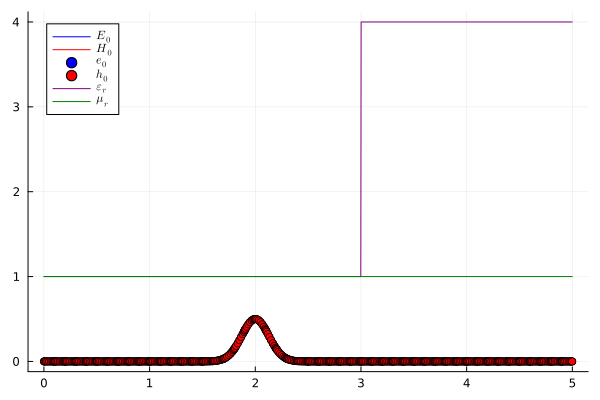

In [902]:
# plot(xx, uana0, color=:blue,label=L"U_0", format=:png)
# plot!(xreal,u0, color=:blue,seriestype=:scatter,label=L"u_0", format=:png)
plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
plot!(xx, Hana0, color=:red,label=L"H_0", format=:png)
# plot!(xx, p00, color=:orange,label=L"P_{00}", format=:png)

plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"e_0", format=:png)
plot!(xreal,dsem.Q[:,2], color=:red,seriestype=:scatter,label=L"h_0", format=:png)
plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)

In [903]:
#element real location boundaries
xk;

In [904]:
#create elements index locations in 1D array
elindex = zeros(Int64, K*2)
elindex[1] = 1
for k in 1:K-1
    elindex[2*k] = elindex[2*k-1] + N[k]
    elindex[2*k+1] = elindex[2*k]+1
end
elindex[end] = K*(N[end]+1);

In [905]:
elindex;

In [906]:
# for k in 1:K
#     #left boundary index
#     lpoint = elindex[2*k-1]
#     #right boundary index
#     rpoint = elindex[2*k]
#     println(lpoint,":", rpoint)
# end

In [907]:
#alg 122 for boundary pointers
#create boundary pointers
eleft = append!([-1],[k for k in 1:K])
eright = append!([k for k in 1:K], [-1])
nodeleft = [Ntot for k in 1:K-1]
noderight = [0 for k in 1:K-1];
epk = EPKD(eleft, eright, nodeleft, noderight);

In [908]:
epk.eleft;

In [909]:
epk.eright;

In [928]:
#alg 88 NDG::NDG2DWaves
# ReimannSolver(NDG.QRint[:,idL], NDG.QRext,  1.0, "LEFT", c, epsr, mur, Z)
function ReimannSolverNDG1DRHMax!(QL::AbstractArray, QR::AbstractArray,  normal::Float64, side::String, epsr::AbstractArray, mur::AbstractArray, c::AbstractArray, Z::AbstractArray)
    #Qout - outgoing corresponds to +
    #Qinc - incoming wave corresponds to -
    #normal is normal to x surface
    #epsr - [1] is incoming eps and [2] is outgoing
    
    ZL = Z[1]
    ZR = Z[2]
    cL = c[1]
    cR = c[2]
    epsL = epsr[1]
    epsR = epsr[2]
    muL = mur[1]
    muR = mur[2]

    EL = QL[1]
    HL = QL[2]
    ER = QR[1]
    HR = QR[2]

    F1 = 0.0
    F2 = 0.0
    
    # FLstar
    if side == "LEFT"
        F1 = normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR)) 
        F2 = normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    elseif side == "RIGHT"
        F1 = -normal*( ZR*cL*(EL + ZL*HL) - ZL*cR*(ER - ZR*HR) )/((ZL+ZR))  
        F2 = -normal*(cL*(EL + HL*ZL) + cR*(ER - ZR*HR))/((ZL+ZR))
    end

    return [F1, F2] #[FLstar1, FLstar2], [FRstar1, Fstar2]
    

end

ReimannSolverNDG1DRHMax! (generic function with 1 method)

In [929]:
#alg 64
function FluxMaxwell(F::AbstractArray, Q::AbstractArray, N::Int64, lpoint::Int64, rpoint::Int64, n::AbstractArray, epsr::AbstractArray, mur::AbstractArray)

    F[:,1] = 1.0 ./ epsr .* Q[lpoint:rpoint, 2]#c^2 * Q[lpoint:rpoint, 2]#rhobulk[2] * Q[lpoint:rpoint, 2]
    F[:,2] = 1.0 ./ mur .* Q[lpoint:rpoint, 1]#Q[lpoint:rpoint, 1] #1.0/rhobulk[1] * Q[lpoint:rpoint, 1]

    return nothing #F1, F2

end


FluxMaxwell (generic function with 1 method)

In [930]:
#external function
# ExternalState(NDG.QLint[:,k], -1.0, NDG.xk[1], t, "LEFT")
function ExtFunFreePropagation(Qint::Array{Float64}, xyBoundary::Float64, xy::Float64, t::Float64, LRTB::String)

    neqn=length(Qint)
    Qext = zeros(Float64, neqn)
    
    if LRTB=="LEFT" #|| LRTB== "RIGHT"
        Qext[1] = 0.0#FeI(xy,t) + FeR(xy,t)#0.0#Fp(xy,t)#Qint[1] #Fp(xy,t)
        Qext[2] = 0.0#FhI(xy,t) + FhR(xy,t)#0.0Fu(xy,t)#-Qint[2] #Fu(xy,t)
        # Qext[3] = Fv(xyBoundary,xy,t)
    elseif LRTB=="RIGHT"
        Qext[1] = 0.0#FeT(xy,t)#Qint[1]#Fp(xy,t) #Fp0(xy,t)
        Qext[2] = 0.0#FhT(xy,t)#-Qint[2]#Fu(xy,t)#Fu0(xy,t)
    end
    return Qext
end

# EI = FeI.(xx,tt)
# HI = FhI.(xx,tt);
# ER = FeR.(xx,tt)
# HR = FhR.(xx,tt);
# ET = FeT.(xx,tt)
# HT = FhT.(xx,tt);

ExtFunFreePropagation (generic function with 1 method)

In [931]:
#CFT Number
ddxx = 5.0/(Ntot - K)
CFT = 1.0
ddtt = CFT/c1*ddxx


0.025

In [932]:
dsema = deepcopy(dsem)
dt = 5.0e-4
ttot = 2.0
NT = floor(Int64, ttot/dt)


4000

In [933]:
tn = 0.0
for n in 0:NT
    if mod(n,100) == 0
        IJulia.clear_output(true)
        println("Time Step: ",n)
    end
    
    @. dsema.G = 0
    @. dsema.dQ = 0

    # DGStepByRK3!(Phi, w, Dhat,g, lp1, ln1, tn, dt, c)
    #ReimannSolverNDG1D
    DGSEMstep1DRK3Max!(dsema, epk, tn, dt, elindex, ExtFunFreePropagation, ReimannSolverNDG1DRHMax!, FluxMaxwell)
    tn = (n+1)*dt
    
    
end

Time Step: 4000


In [934]:
dsema.Q[1,1]

-1.0482254937851003e-16

In [935]:
tt = ttot
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

EE = @. EI+ER+ET
HH = @. HI+HR+HT;

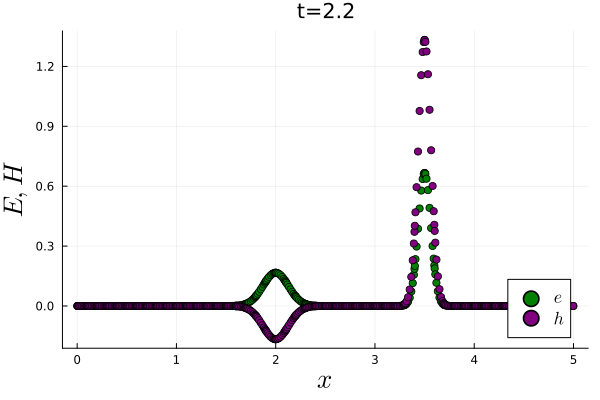

In [973]:

# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h", format=:png)
# plot!(xx, EE, color=:blue,label=L"E", linewidth=2.0,format=:png)
# plot!(xx, HH, color=:red,label=L"H", linewidth=2.0,format=:png)
# vline!([3], color=:darkblue, linewidth=2, label="")
# annotate!(1.5, 0.5, text(L"\epsilon_r = 1", :darkblue, :right, 16))
# annotate!(4.5, 0.5, text(L"\epsilon_r = 1.25", :darkblue, :right, 16))
# annotate!(1.3, -0.3, text("Left wave", :black, :right, 10))
# annotate!(1.8, 0.2, text("Reflected wave\n"*L"|E_R|=0.14 \: E_I", :black, :left, 10))
# annotate!(3.1, -0.1, text("Transmitted wave\n"*L"|E_T|=0.85 \: E_I", :black, :left, 10))
# plot!(xreal, epsr, color=:purple,label=L"\epsilon_r", format=:png)
# plot!(xreal, mur, color=:green,label=L"\mu_r", format=:png)
plot!(title="t=2.2", legend=:bottomright, legendfontsize=12)#, xlim=(3.0,4.0), ylim=(0,1.35))
# vline!([3], color=:darkblue, linewidth=2, label="")
# hline!([0.675], color=:darkblue, linewidth=2, label="")
# vline!([3.425], color=:darkblue, linewidth=2, label="")
# vline!([3.575], color=:darkblue, linewidth=2, label="")

xlabel!(L"x", guidefont=18)
ylabel!(L"E,H", guidefont=18)


In [972]:
1.35/2

0.675

In [ ]:
.3

In [971]:
0.15

0.15

In [950]:
0.175/2.0

0.0875

In [850]:
Z0/Z1

2.0

In [689]:
X0

2.0

In [690]:
ERef

-0.3333333333333333

In [691]:
ETran

0.6666666666666666

In [3599]:
c0*ttot

2.2

In [3600]:
c1*ttot

1.967739820199815

In [3584]:
maximum((dsema.Q[:,1]))

0.47270922756914535

In [3585]:
maximum((dsema.Q[:,2]))

0.4825932284629805

In [692]:
0.5*ETran

0.3333333333333333

In [975]:
0.5*ETran/Z1

0.6666666666666666

In [3509]:
0.5*ETran/Z1/maximum((dsema.Q[:,2]))

0.8960727898804876

In [3510]:
Z1/Z0

0.8944271909999159

In [3503]:
maximum(EE)

0.4675807813773784

In [3504]:
maximum(HH)

0.5227712060661429

In [3501]:
maximum(abs.(dsema.Q[1:200,2]))

0.14208608513183651

In [2803]:
maximum(EE)*ETran

0.42910840203247674

In [2804]:
maximum(EE)*ETran/Z1

0.47975777833046346

In [3464]:
dsema.Q[1,1]

NaN

In [3465]:
length(EE)

101

In [3466]:
minimum(EE[30:60])

-0.02786404500042062

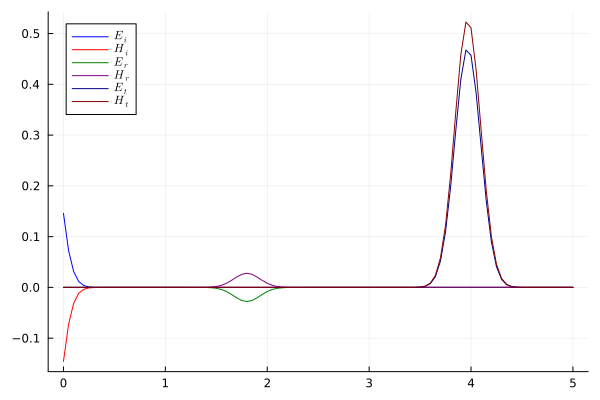

In [3467]:
plot(xx, EI, color=:blue,label=L"E_i", format=:png)
plot!(xx, HI, color=:red,label=L"H_i", format=:png)
plot!(xx, ER, color=:green,label=L"E_r", format=:png)
plot!(xx, HR, color=:purple,label=L"H_r", format=:png)
plot!(xx, ET, color=:darkblue,label=L"E_t", format=:png)
plot!(xx, HT, color=:darkred,label=L"H_t", format=:png)

In [2805]:
length(dsema.Q[:,1])

450

In [2806]:
maximum(dsema.Q[200:end,1]), maximum(dsema.Q[200:end,2])

(0.4959089034162212, 0.5544430093430239)

In [2668]:
# plot(xx, Eana0, color=:blue,label=L"E_0", format=:png)
# plot!(xx, Hana0, color=:red,label=L"E_0", format=:png)
# plot!(xx, pt, color=:green,label=L"E_t", format=:png)
# plot!(xx, ut, color=:purple,label=L"H_t", format=:png)
# # plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
# plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

We must benchmark with theoretical solution. 

The initial incident waves travelling to the right that hit the interface are: 

\begin{align}
    E_I &= \tilde{E}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_I &= \tilde{H}_{I0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{I0} &= \frac{1}{2} 2^{ -\frac{(x -c_0 t -1)^2}{b^2}} \\
    \tilde{H}_{I0} &= \frac{1}{2 Z}  2^{ -\frac{(x -c_0 t -1)^2}{b^2}}
\end{align}


On the left, $\epsilon_1 = 1.0$ and on the right $\epsilon_2 = 1.7$ and $\mu_L = \mu_R = 1.0$

When the incident wave hits the interface, a reflected and transmitted wave are created. 

We use the solution given by Griffiths. According to Griffiths 

\begin{align}
    E_R &= \tilde{E}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} \\
    H_R &= -\tilde{H}_{R0} \: \: e^{i \left(  k_0 x -\omega_0 t  \right)} 
\end{align}

and

\begin{align}
    E_T &= \tilde{E}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} \\
    H_T &= \tilde{H}_{T0} \: \: e^{i \left(  k_1 x -\omega_1 t  \right)} 
\end{align}



Where the amplitudes are given by 

\begin{align}
    \tilde{E}_{R0} &= R \cdot \tilde{E}_{I0} \\
    \tilde{H}_{R0} &= \frac{1}{Z_0} \tilde{E}_{R0}
\end{align}

\begin{align}
    \tilde{E}_{T0} &= T \cdot \tilde{E}_{I0} \\
    \tilde{H}_{T0} &= \frac{1}{Z_1} \tilde{E}_{T0}
\end{align}

$R$ and $T$ are the reflection and transmission coefficeints 

Eqn 81 we have: 

\begin{align}
    \beta = \frac{Z_0}{Z_1}
\end{align}

And the amplitudes for the reflected and transmitted waves: 

\begin{align}
    \tilde{E}_{R0} &= \frac{1-\beta}{1+\beta} \tilde{E}_{I0}\\
    \tilde{E}_{T0} &= \frac{2}{1+\beta} \tilde{E}_{I0}
\end{align}

In [2872]:
Beta = Z0/Z1

1.118033988749895

In [2873]:
ERef = (1-Beta)/(1+Beta)

-0.05572809000084124

In [2874]:
ETran = 2.0/(1+Beta)

0.9442719099991588

In [2875]:
ETran/Z1

1.0557280900008412

In [2876]:
function FeI(x,t)
    FE = 0.0
    if x < xeps
        FE = 0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2) + 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhI(x,t)
    FH = 0.0
    if x < xeps
        FH = 0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2) - 2^(-((x-X0) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhI (generic function with 1 method)

In [2877]:
function FeR(x,t)
    FE = 0.0
    if x < xeps
        FE = ERef*0.5*( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhR(x,t)
    FH = 0.0
    if x < xeps
        FH = -ERef*0.5/impZ(x) *( 2^(-((x-(xeps + (xeps-X0))) + t*speedc(x))^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhR (generic function with 1 method)

In [2878]:
function FeT(x,t)
    FE = 0.0
    if x >= xeps
        FE = ETran*0.5*( 2^(-((x-X0) - t*speedc(x))^2/b^2))
    else
        FE=0.0
    end
    return FE
end
function FhT(x,t)
    FH = 0.0
    if x >= xeps
        FH = ETran*0.5/impZ(x) * (2^(-((x-X0) - speedc(x)*t)^2/b^2))
    else
        FH=0.0
    end
    return FH
end

FhT (generic function with 1 method)

In [2717]:
tt = 0.5
EI = FeI.(xx,tt)
HI = FhI.(xx,tt);
ER = FeR.(xx,tt)
HR = FhR.(xx,tt);
ET = FeT.(xx,tt)
HT = FhT.(xx,tt);

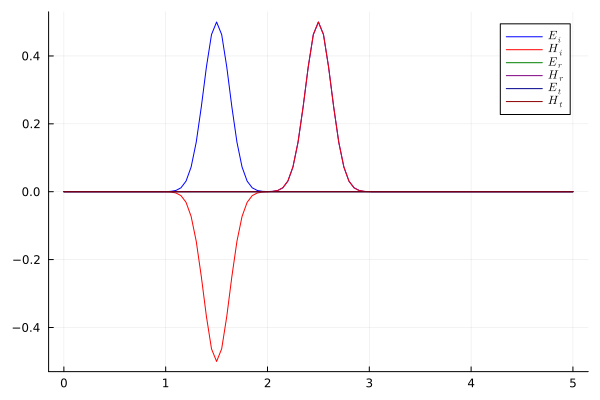

In [2719]:
plot(xx, EI, color=:blue,label=L"E_i", format=:png)
plot!(xx, HI, color=:red,label=L"H_i", format=:png)
plot!(xx, ER, color=:green,label=L"E_r", format=:png)
plot!(xx, HR, color=:purple,label=L"H_r", format=:png)
plot!(xx, ET, color=:darkblue,label=L"E_t", format=:png)
plot!(xx, HT, color=:darkred,label=L"H_t", format=:png)
# plot!(xreal,dsem.Q[:,1], color=:blue,seriestype=:scatter,label=L"p_t", format=:png)
# plot!(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
# plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [2720]:
maximum(EI)

0.5000000000000209

In [2721]:
maximum(HI)

0.49999999999997913

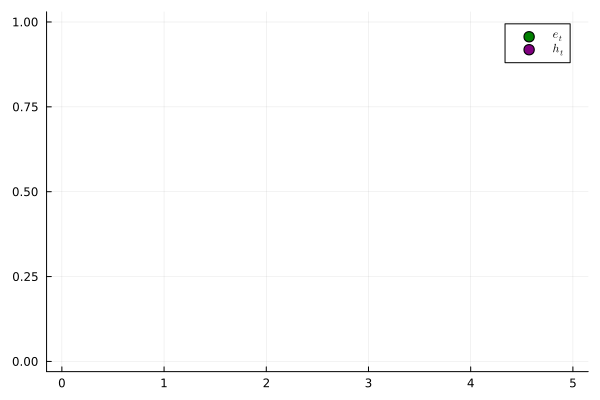

In [1495]:
plot(xreal,dsema.Q[:,1], color=:green,seriestype=:scatter,label=L"e_t", format=:png)
plot!(xreal,dsema.Q[:,2], color=:purple,seriestype=:scatter,label=L"h_t", format=:png)

In [1206]:

#LegendreNDG1DWave!(dsema, epk, NT, dt, 1, elindex, ExtFunFreePropagation, ReimannSolverNDG1D, Flux)

In [2226]:
dsema.Q[1,1]

NaN

Again we do the eigen analysis to diagonalize our equation:

\begin{align}
    \underline{S} = \left[ \begin{array}{cc} 
    \sqrt{\mu / \epsilon} && -\sqrt{\mu / \epsilon} \\
    1 && 1
    \end{array}\right]
\end{align}

and

\begin{align}
    \underline{S}^{-1} = \frac{1}{2} \left[ \begin{array}{cc} 
    \sqrt{\epsilon / \mu } && 1  \\
    -\sqrt{\epsilon / \mu} && 1
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^+ = \left[ \begin{array}{cc} 
    c && 0 \\
    0 && 0
    \end{array}\right]
\end{align}

\begin{align}
    \underline{\Lambda}^- = \left[ \begin{array}{cc} 
    0 && 0 \\
    0 && -c
    \end{array}\right]
\end{align}

Using $Z = \sqrt{\mu / \epsilon}$

Also note that both $\mu$, $\epsilon$, and $c$ change with respect to position and therefore change with respect to which side of the surface boundary they're at

\begin{align}
    \underline{S}^{-1} \cdot \bar{q} =  \frac{1}{2} \left[ \begin{array}{cc} 
   \frac{1}{Z^+}\cdot E_y + H_z  \\
    \frac{-1}{Z^-}\cdot E_y + H_z 
    \end{array}\right] = \frac{1}{2}  \left[ \begin{array}{cc} 
   w^+\\
    w^-
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{+} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   c^+ \cdot w^+\\
    0
    \end{array}\right]
\end{align}


\begin{align}
    \underline{\Lambda}^{-} \cdot \underline{S}^{-1} \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   0\\
    -c^- \cdot w^-
    \end{array}\right]
\end{align}

\begin{align}
    F^* = \left( \underline{S} \cdot \underline{\Lambda}^{+} \cdot \underline{S}^{-1} +   \underline{S} \cdot\underline{\Lambda}^{-} \cdot \underline{S}^{-1}  \right)  \cdot \bar{q} = \frac{1}{2} \left[ \begin{array}{cc} 
   Z \left( w^+ + w^-  \right) \\
    w^+ - w^-
    \end{array}\right] = \frac{c}{2} \left[ \begin{array}{cc} 
     E^+_y + Z\: H_z^+ - E_y^- + Z\: H_z^-   \\
    \frac{E_y^+}{Z} + H_z^+ + \frac{E_y^-}{Z} - H_z^- 
    \end{array}\right]
\end{align}

In [1016]:
#alg 116
mutable struct DSEM1D

    N::Int64
    K::Int64
    xi::Array{Float64} #node locations
    wk::Array{Float64} #Gauss-Lobatto quad weights
    wbk::Array{Float64} #Barycentric weights
    xk::Array{Float64} #Element Boundary Locations
    dxk::Array{Float64} #Element sizes
    xkL::Array{Float64} #left boundary of elements
    xkR::Array{Float64} #Right boundary of elements
    Q::Array{Float64} #Solution, 2D matrix with (j,k) where j are nodes and k are element
    dQ::Array{Float64} #right hand side, 2D matrix with (j,k) where j are nodes and k are element
    G::Array{Float64} #Low Storage RK3
    QL::Array{Float64} # solution at left element boundaries
    QR::Array{Float64} #solution at right element boundaries
    FstarR::Array{Float64} #numerical flux on the right of elements
    FstarL::Array{Float64} #numerical flux on left of elements


end

#seperate struct for element boundary pointers
mutable struct EPK

    eleft::Vector{Int64}
    eright::Vector{Int64}
    nodeleft::Vector{Int64}
    noderight::Vector{Int64}

end

LoadError: invalid redefinition of constant Main.DSEM1D

In [1017]:
#alg 117
function maskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    nR = 0
    for k in 1:K-1
        # kk=k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        a[nR] = 0.0

    end
    

end

function unmaskSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    nR = 0
    nL = 0
    for k in 1:K-1
        # kk=k
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)
        
        a[nR] = a[nL]

    end
    

end


function globalsumSEM!(a::AbstractArray, pk::EPK, N::Int64, K::Int64)

    jR = 0
    eR = 0
    jL = 0
    eL = 0
    tmp = 0.0
    nR = 0
    nL = 0
    #might need to handle the k=0 element somehow
    for k in 1:K-1
        # kk = k+1
        jR = pk.noderight[k]
        eR = pk.eright[k]
        #convert to 1D array index
        # nR = eR*N + jR
        nR = (eR-1)*(N+1) + (jR+1)
        jL = pk.nodeleft[k]
        eL = pk.eleft[k]
        #convert to 1D array index
        # nL = eL*N + jL
        nL = (eL-1)*(N+1) + (jL+1)

        tmp = a[nR] + a[nL] #a[jR,eR] + a[jL,eL]
        a[nR] = tmp # a[jR,eR] = tmp
        a[nL] = tmp # a[jL,eL] = tmp

    end
    

end

globalsumSEM! (generic function with 1 method)